In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set(rc={'figure.figsize':(15, 7)}, style='darkgrid')

##  Подготовка

Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
#!pip3 install kaggle

In [5]:
#!kaggle competitions download -c nyc-taxi-trip-duration -f train.zip

Колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, преобразуем даты в `datetime`-объекты

In [6]:
#!unzip train.zip

In [7]:
data = pd.read_csv('train.csv')
data = data.drop('dropoff_datetime', axis=1)

In [8]:
data['pickup_datetime'] = data['pickup_datetime'].apply(lambda x:  datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке.

Text(0.5, 0, 'time')

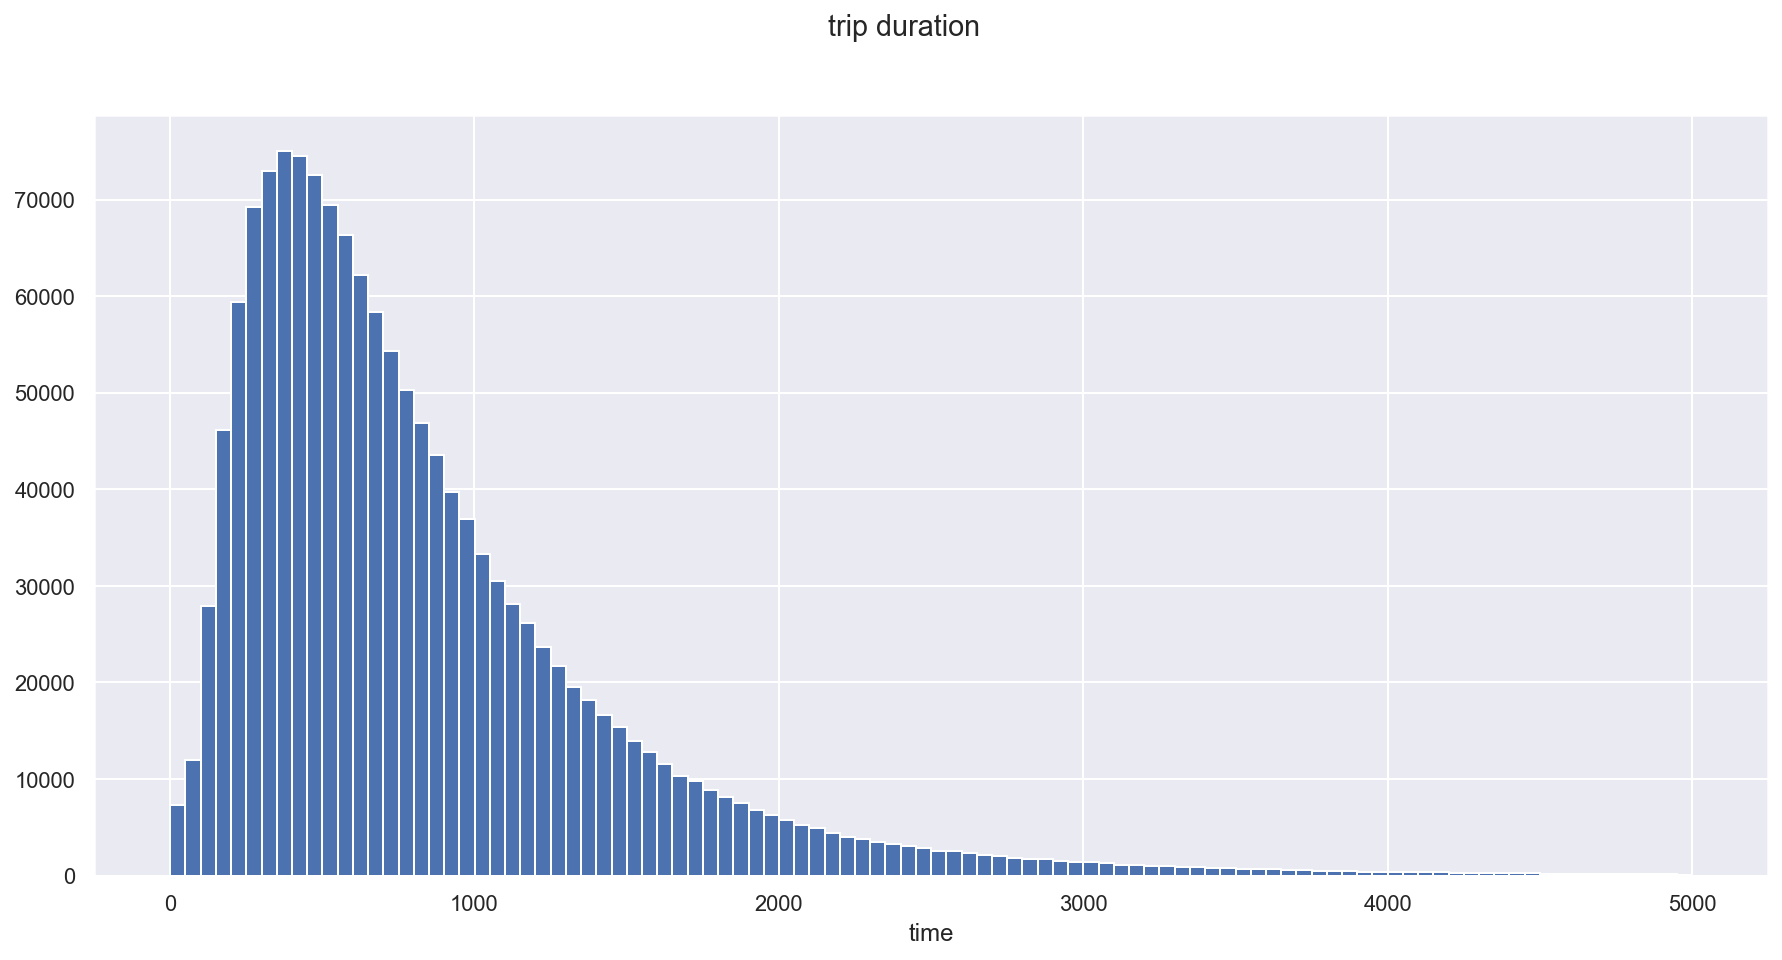

In [9]:
data.trip_duration[data.trip_duration < 5000].hist(bins= 100)
plt.suptitle('trip duration')
plt.xlabel('time')

<AxesSubplot:>

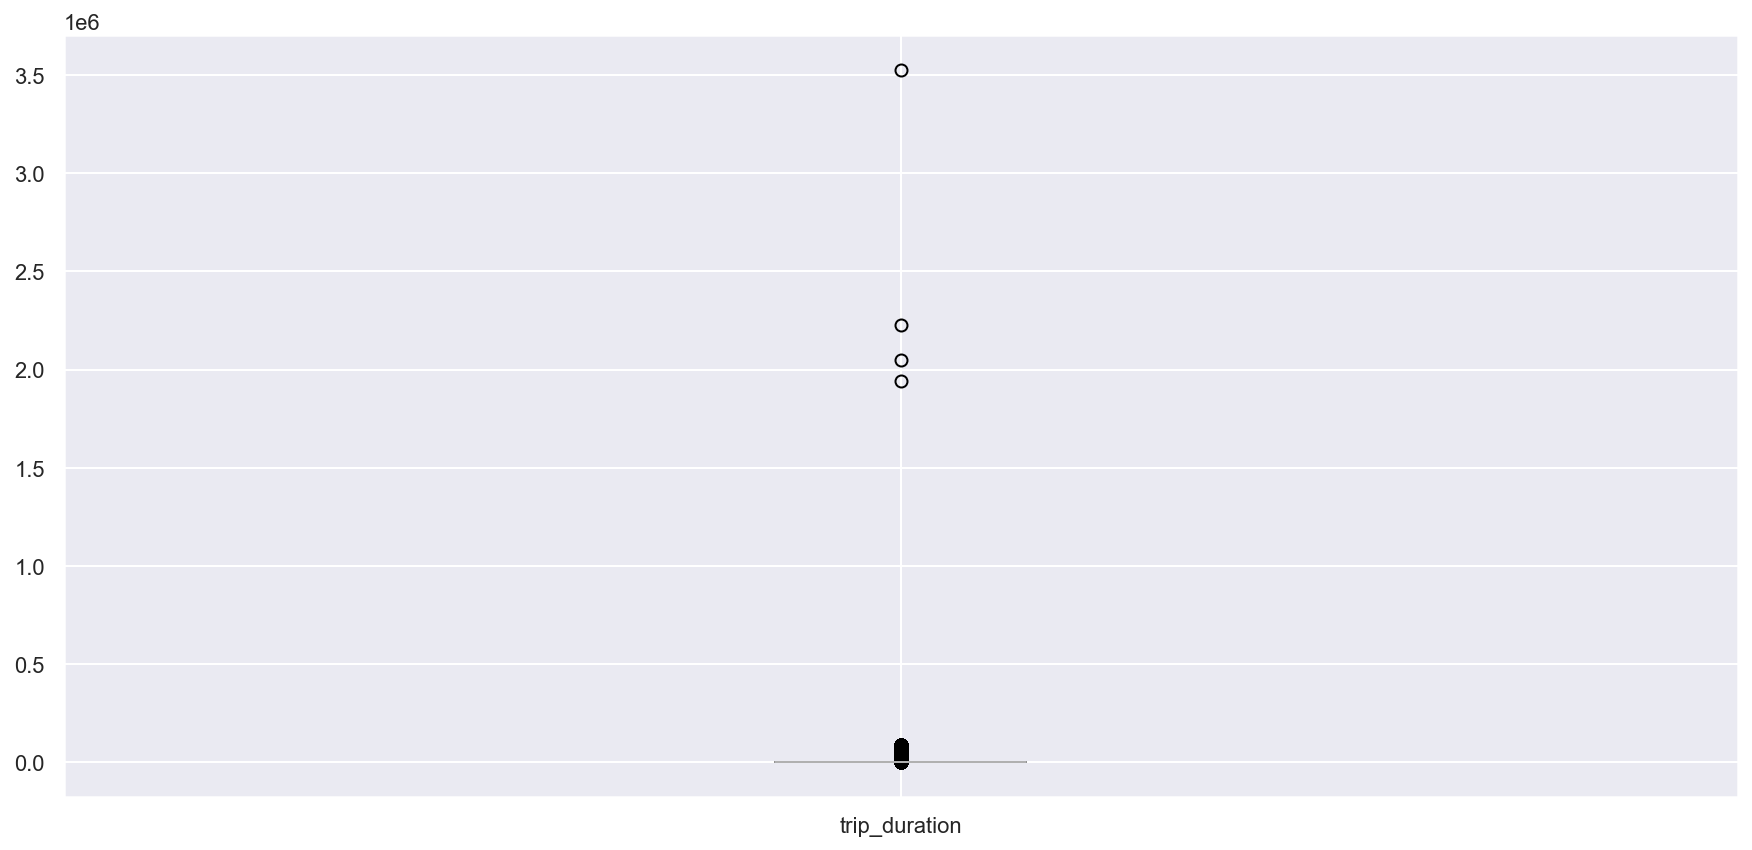

In [10]:
data.boxplot(column = ['trip_duration'])

По ящику с усами видны огромные выбросы. Распределение целевой переменной без выбросов похоже на логнормальное

В соревновании в качестве метрики качества использовалось RMSLE, а не RMSE, это можно обяснить:
1) Потому что, если взять логарифм от исходного распределения, получим нормальное распределения, с ним в разы проще работать

2) Логарифм не обращает внимание на порядок величин, то есть мы будем уменьшать относительную ошибку, а не абсолютную

3) RMSLE штрафует сильнее за недооценку, чем за переоценку

Так как модели линейной регрессии в `sklearn` оптимизируют среднеквадратичную ошибку (MSE), а не RMSLE проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

In [11]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])
data = data.drop('trip_duration', axis=1)

Text(0.5, 0, 'log(time)')

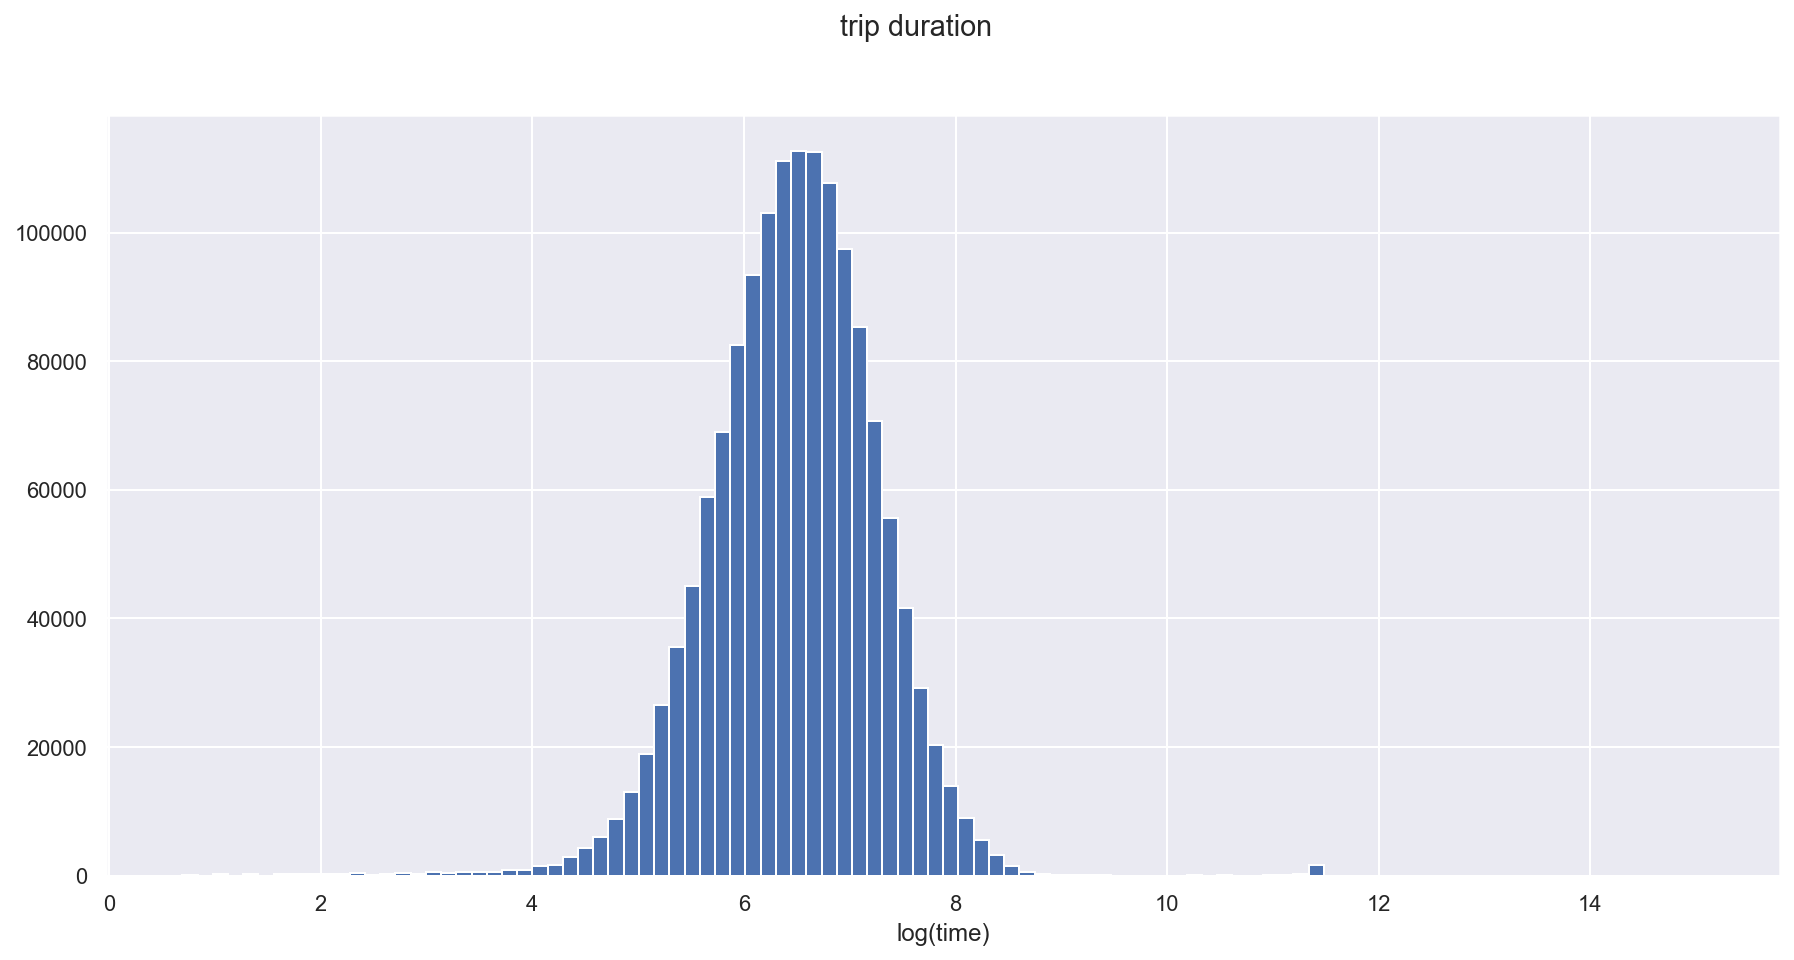

In [12]:
data.log_trip_duration[data.log_trip_duration < 5000].hist(bins= 100)
plt.suptitle('trip duration')
plt.xlabel('log(time)')

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [13]:
from sklearn.metrics import mean_squared_error as mse
# оптимальная - выборочное среднее, так как это несмещенная, состоятельная и ассимптотически нормальная оценк  
mse(data.log_trip_duration, data.log_trip_duration.mean()*np.ones(data.log_trip_duration.shape), squared=False)

0.7957592365411509

Часть 1. Изучаем `pickup_datetime`

Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Построим график зависимости количества поездок от дня в году

Text(0, 0.5, 'number of trips')

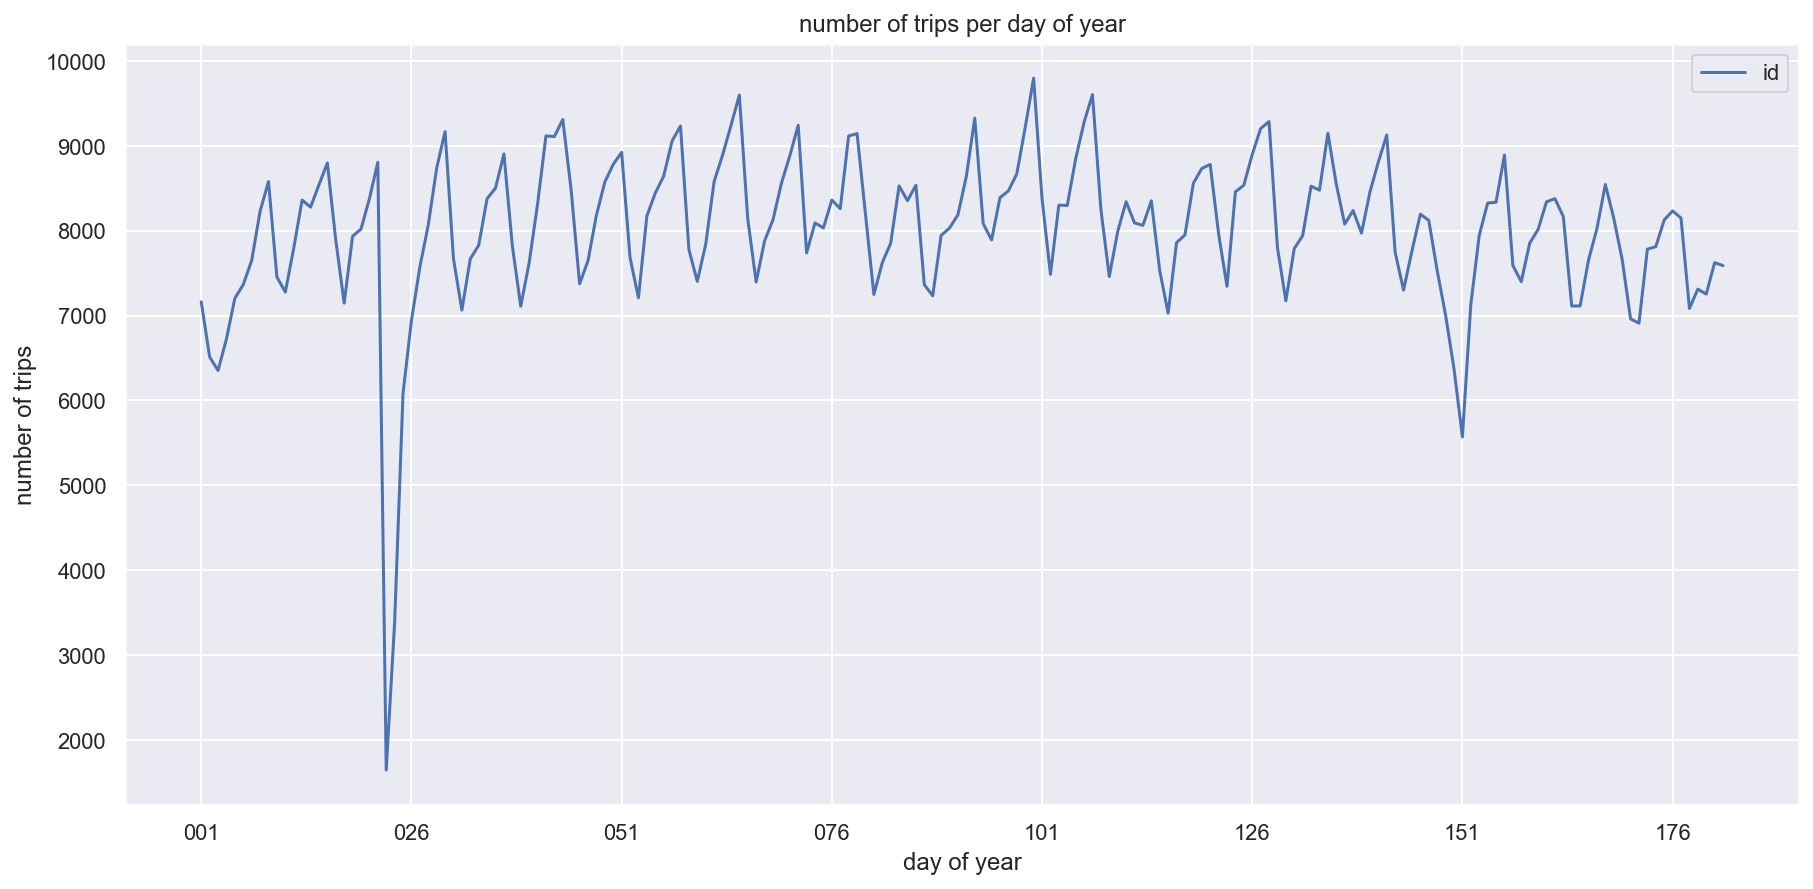

In [14]:
#data.set_index('pickup_datetime').resample('D').id.count().plot()
data.apply({'pickup_datetime': lambda x: x.strftime('%j'), 'id':lambda x: x}).groupby('pickup_datetime').agg({'id':'count'}).plot()
plt.title('number of trips per day of year')
plt.xlabel('day of year')
plt.ylabel('number of trips')

In [15]:
data.set_index('pickup_datetime').resample('D').id.count().nsmallest(10)

pickup_datetime
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
2016-05-29    6372
2016-01-02    6512
2016-01-04    6725
2016-06-20    6910
2016-01-26    6941
Name: id, dtype: int64

По графику видно есть 2 периода с аномально маленькими количествами поездок. Это можно объяснить.

2016-01-23: Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури

https://www.nbcnewyork.com/news/local/nyc-new-york-city-blizzard-biggest-ever-january-23-2016/831660/

2016-05-30: Возможно, причинами могли стать следующие факторы:

1) https://en.wikipedia.org/wiki/Memorial_Day

2) https://tass.ru/proisshestviya/3324970


Посмотрим на графики зависимости количества поездок от дня недели и от часов в сутках

In [16]:
#data.sample(5)

Text(0, 0.5, 'number of trips')

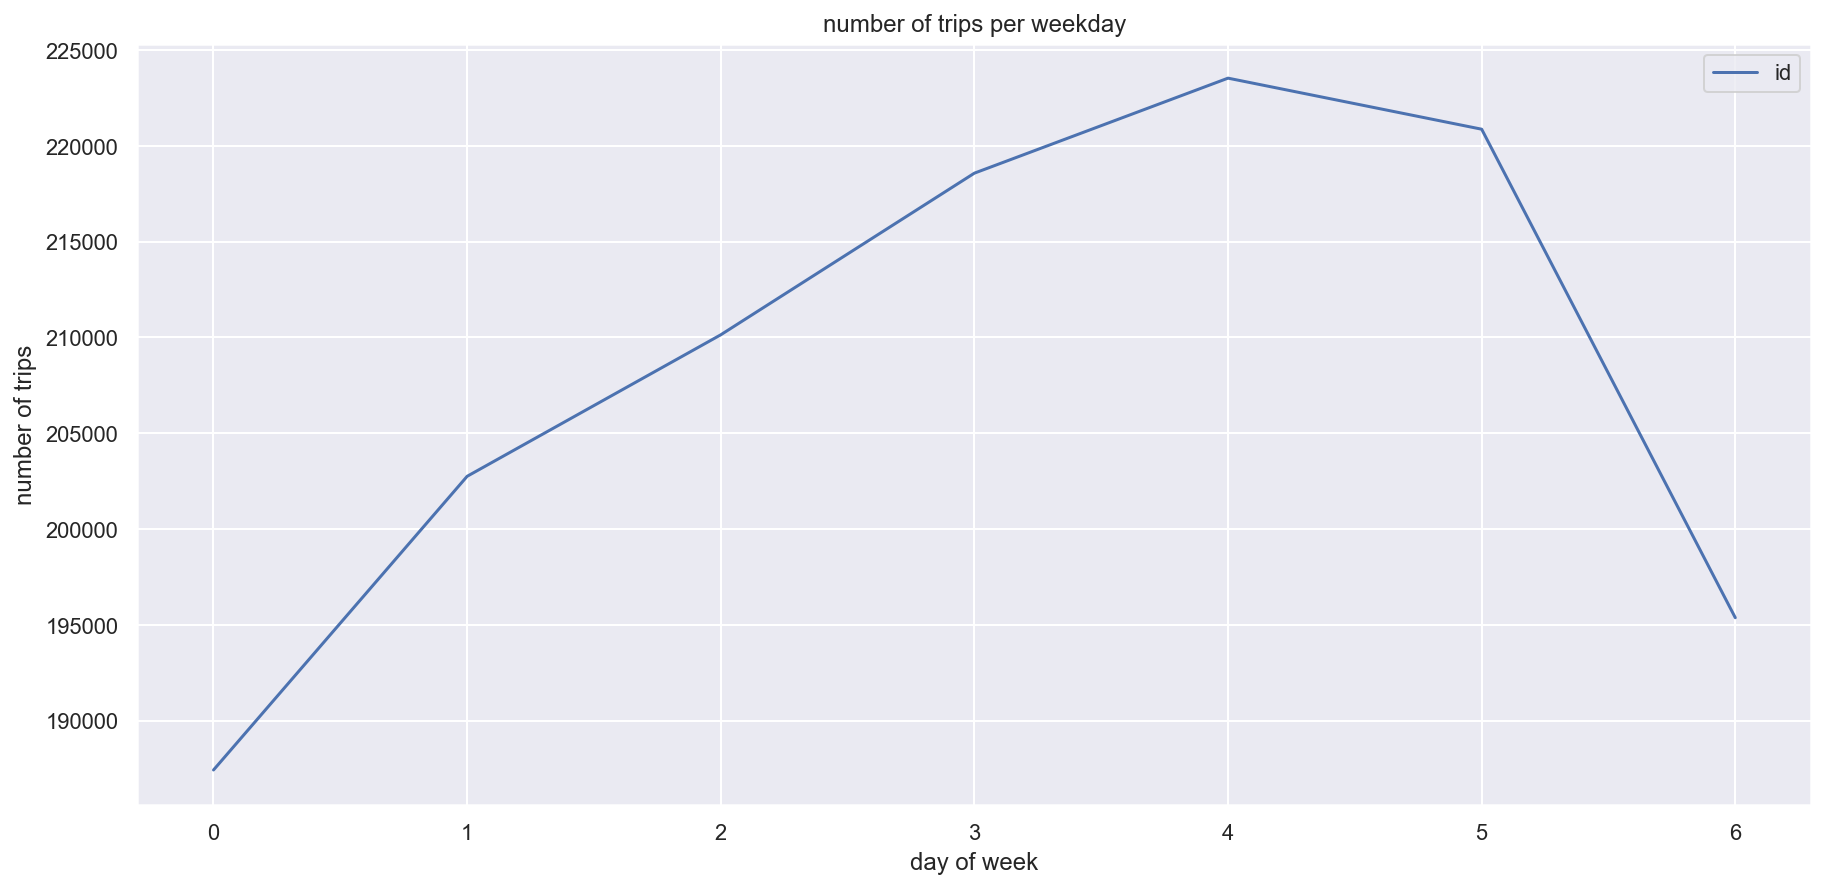

In [17]:
data.apply({'pickup_datetime': lambda x: x.weekday(), 'id':lambda x: x}).groupby('pickup_datetime').agg({'id':'count'}).plot()
plt.title('number of trips per weekday')
plt.xlabel('day of week')
plt.ylabel('number of trips')

Text(0, 0.5, 'number of trips')

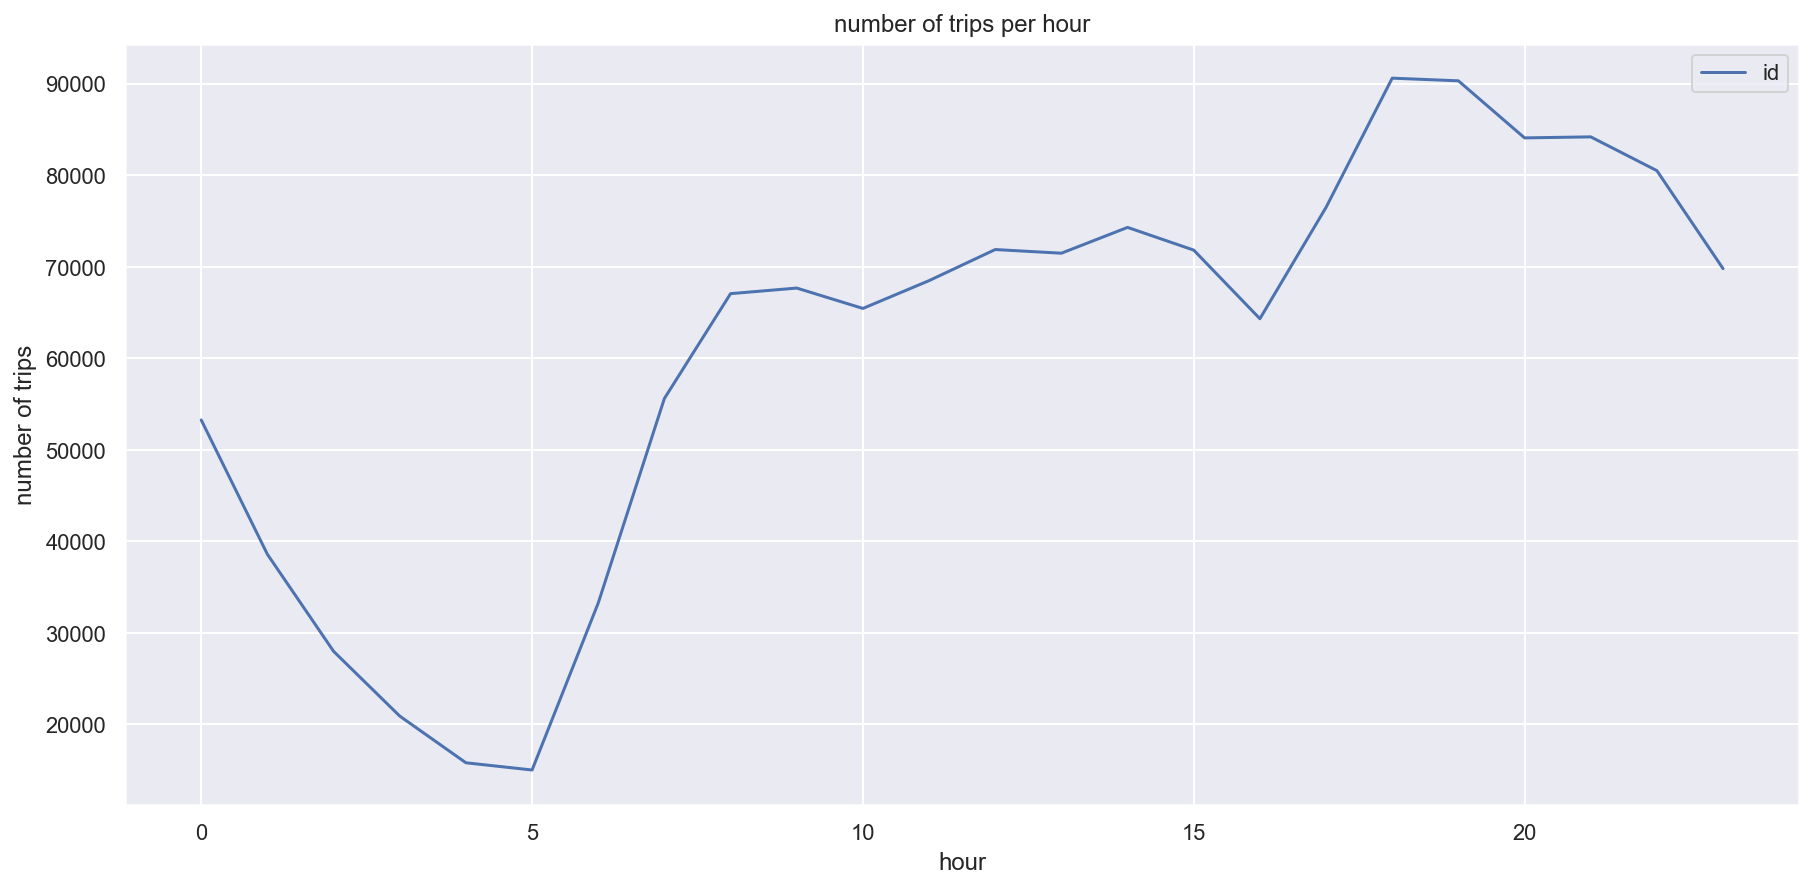

In [18]:
data.apply({'pickup_datetime': lambda x: x.hour, 'id':lambda x: x}).groupby('pickup_datetime').agg({'id':'count'}).plot()
plt.title('number of trips per hour')
plt.xlabel('hour')
plt.ylabel('number of trips')

Нарисуем на одном графике зависимости количества поездок от часа в сутках для разных месяцев. Аналогично  для зависимости количества поездок от часа в сутках для разных дней недели.

In [20]:
#data.apply({'pickup_datetime': lambda x: x.hour, 'pickup_datetime': lambda x: x.month,'id':lambda x: x})
#sns.relplot(data, x = )
data_1 = data.apply({'pickup_datetime': lambda x: x,'id':lambda x: x})
data_1['pickup_hour'] = data.pickup_datetime.apply(lambda x: x.hour)
data_1['pickup_month'] = data.pickup_datetime.apply(lambda x: x.strftime("%B"))
data_1['pickup_weekday'] = data.pickup_datetime.apply(lambda x: x.strftime("%A"))

Text(0.5, 1.0, 'num of trips per hour')

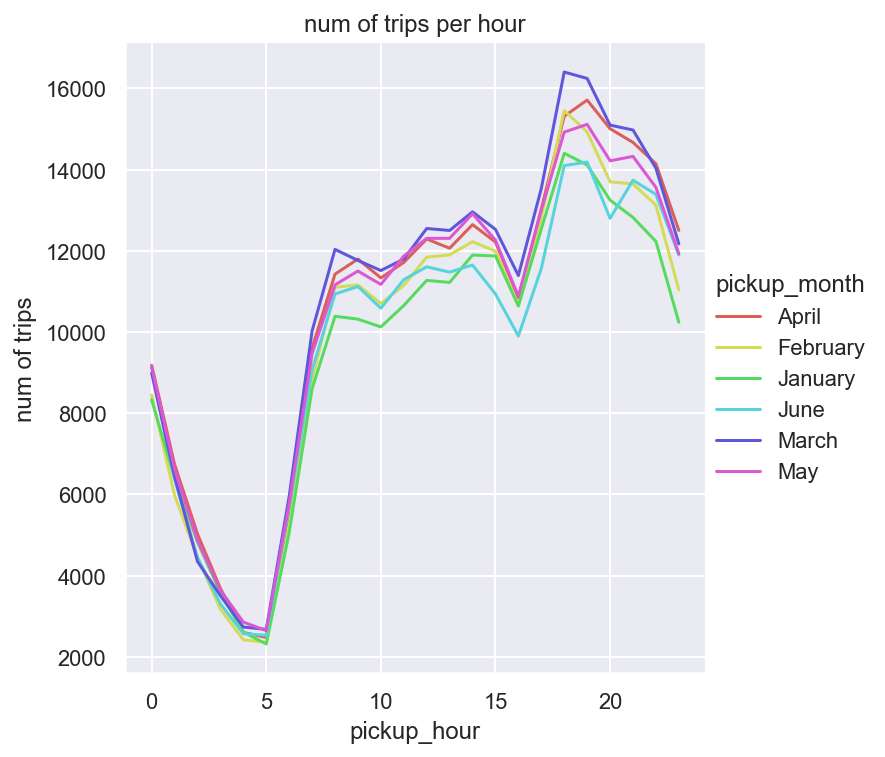

In [21]:
data_grouped_hour_month = pd.DataFrame(data_1.groupby(by = ['pickup_hour', 'pickup_month'], as_index=False).id.count())
sns.relplot(data = data_grouped_hour_month, x = 'pickup_hour', y ='id', kind="line", hue = 'pickup_month', palette = "hls")
plt.ylabel("num of trips")
plt.title("num of trips per hour") 

Text(0.5, 1.0, 'num of trips per hour')

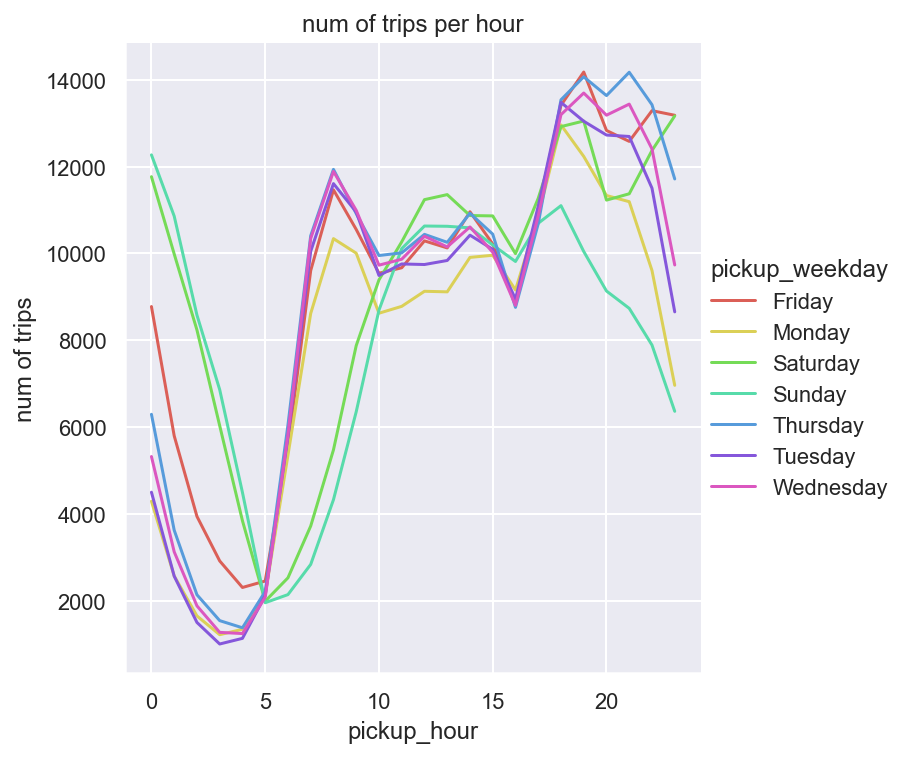

In [22]:
data_grouped_hour_weekday = pd.DataFrame(data_1.groupby(by = ['pickup_hour', 'pickup_weekday'], as_index=False).id.count())
sns.relplot(data = data_grouped_hour_weekday, x = 'pickup_hour', y ='id', kind="line", hue = 'pickup_weekday', palette = "hls")
plt.ylabel("num of trips")
plt.title("num of trips per hour") 

Анализ второго графика:

1) виден сдвиг относительно 5 часов утра, для двух графиков: Суббота, Воскресенье видно увеличенно количество поездок с 0 до 5 утра, и уменьшение с5 до 10, потом снова пик с 10 до 15. Первый скачек связан с гулющими людьми, второй с тем, что в эти дни люди отдыхают, и третий с тем, что в среднем люди позже просыпаются в выходные 


In [23]:
from sklearn.model_selection import train_test_split

#y = data['log_trip_duration']
#X = data.drop(columns = ['log_trip_duration'])

data_train, data_test = train_test_split(data, test_size=0.3, random_state=1337)

Text(0, 0.5, 'count')

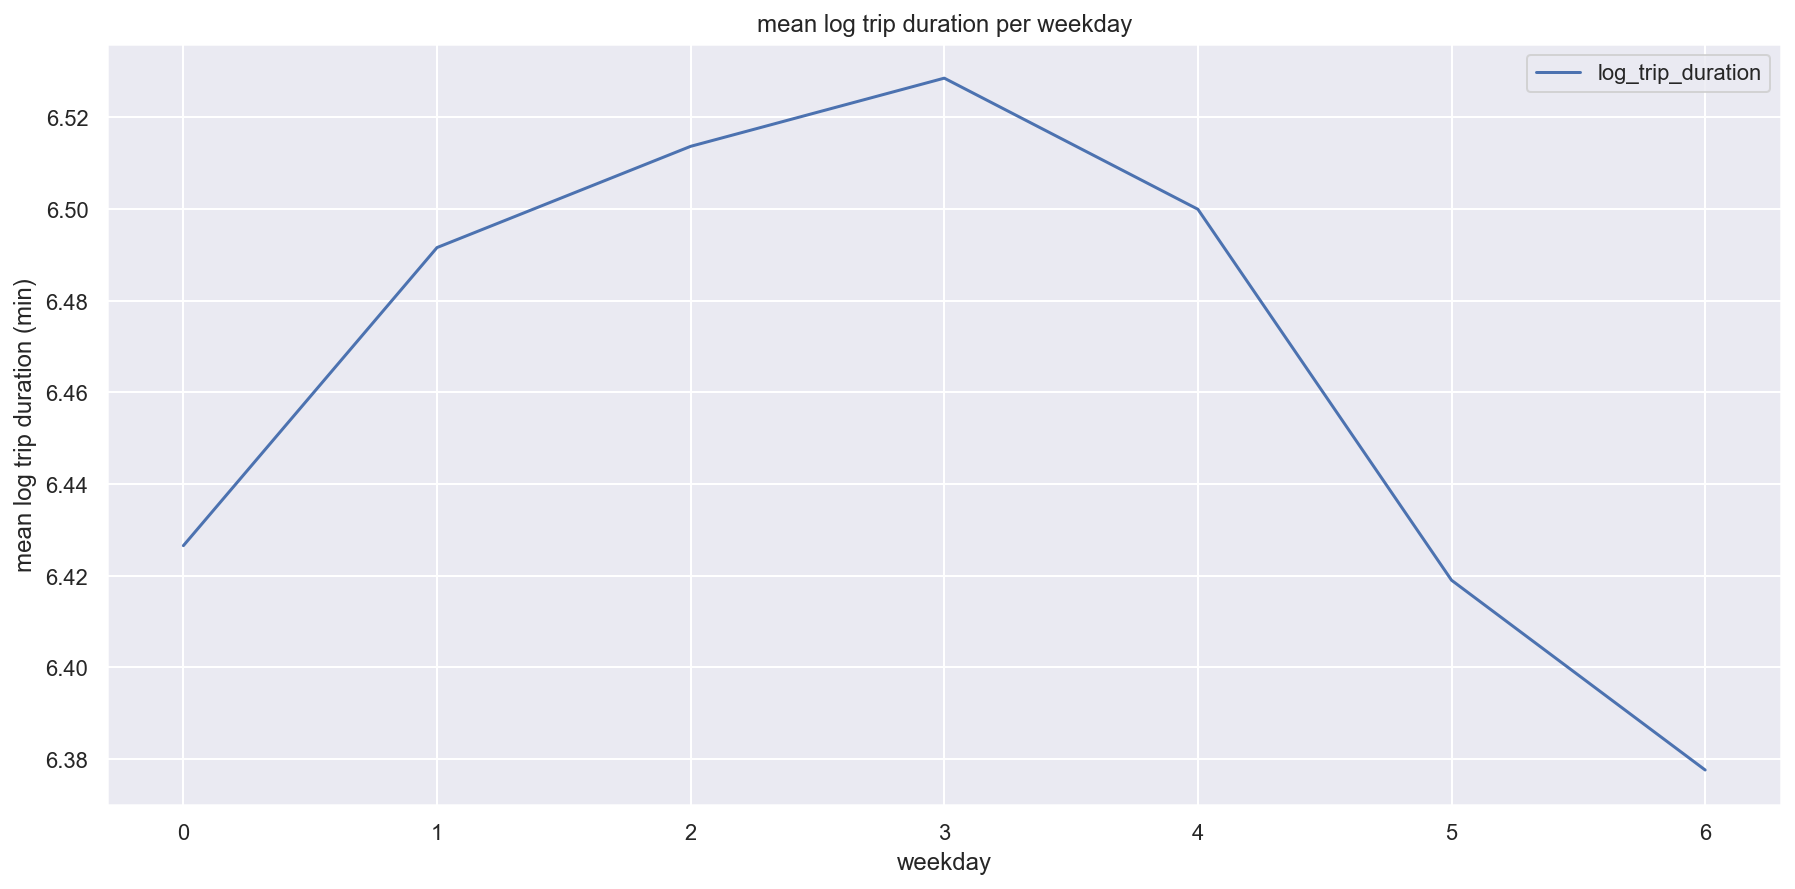

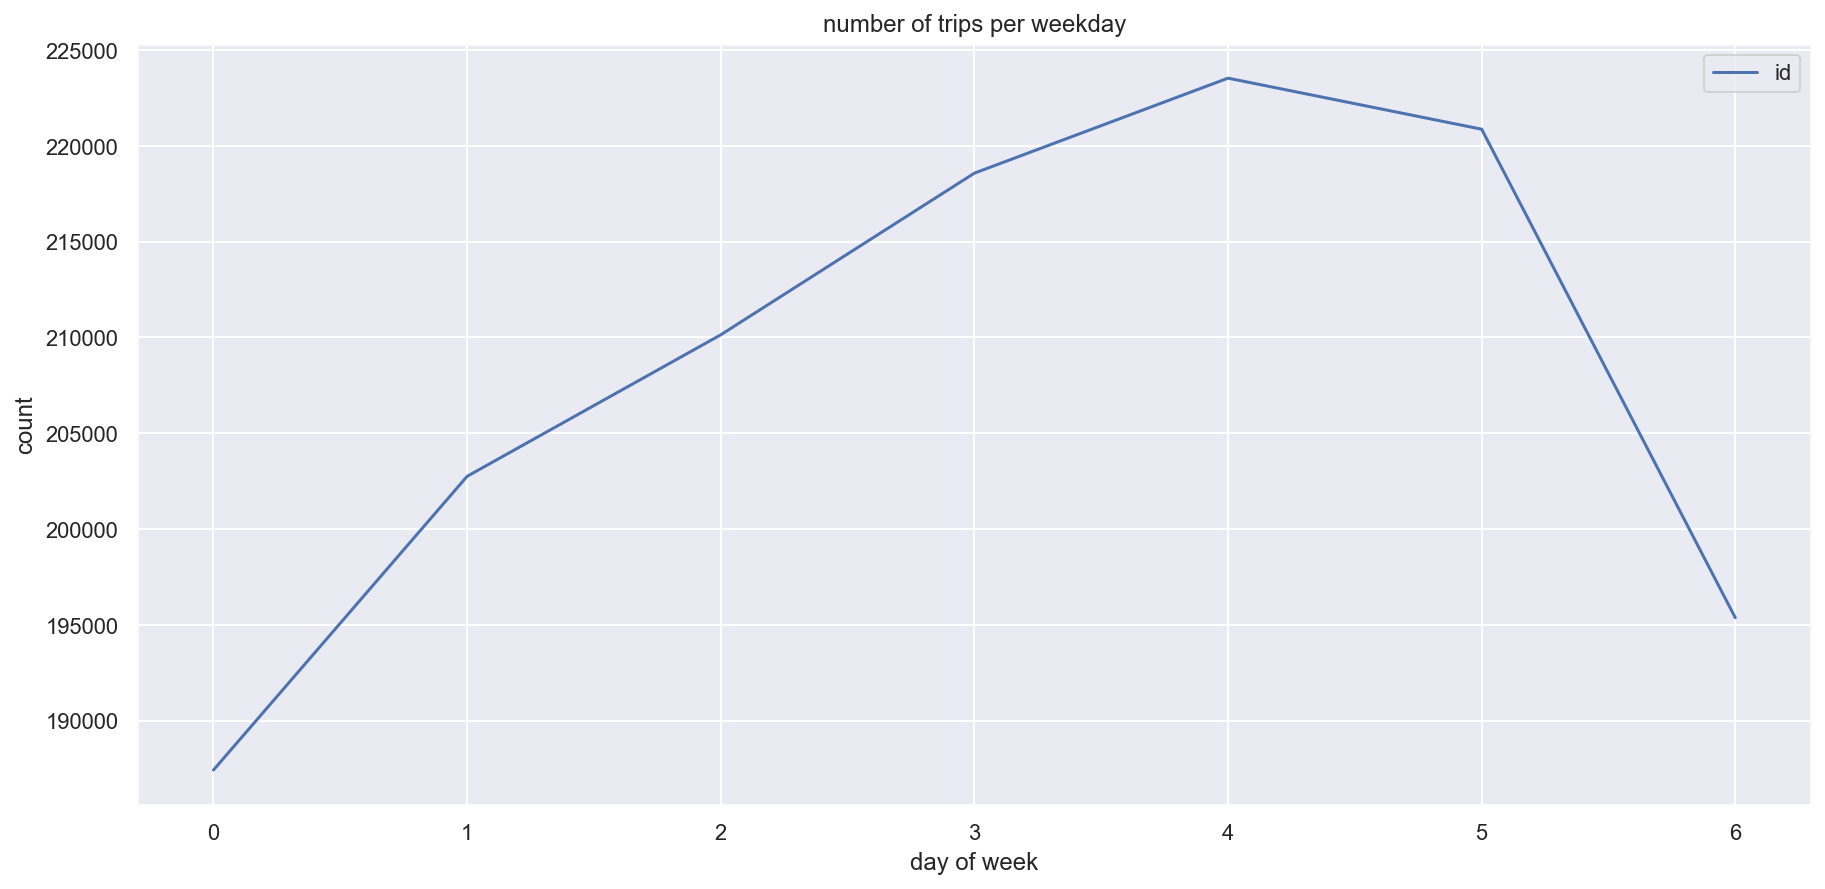

In [24]:
data.apply({'pickup_datetime': lambda x: x.weekday(), 'log_trip_duration':lambda x: x}).groupby('pickup_datetime').agg({'log_trip_duration':'mean'}).plot()
plt.title('mean log trip duration per weekday')
plt.xlabel('weekday')
plt.ylabel('mean log trip duration (min)')

data.apply({'pickup_datetime': lambda x: x.weekday(), 'id':lambda x: x}).groupby('pickup_datetime').agg({'id':'count'}).plot()
plt.title('number of trips per weekday')
plt.xlabel('day of week')
plt.ylabel('count')

Text(0, 0.5, 'count')

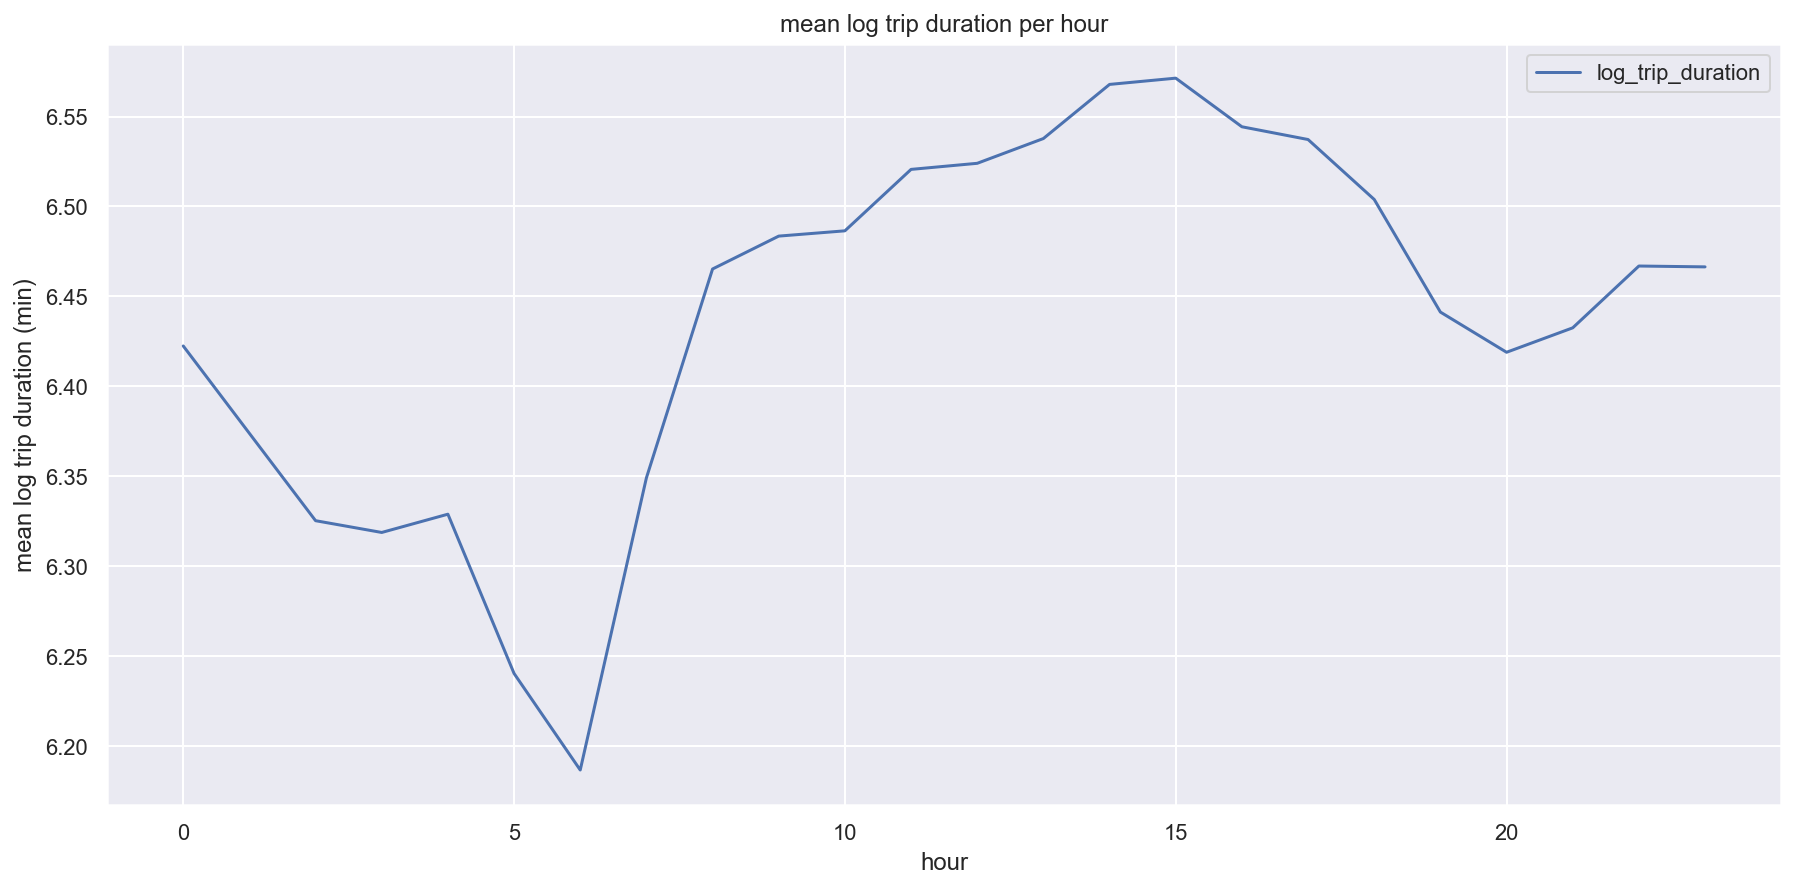

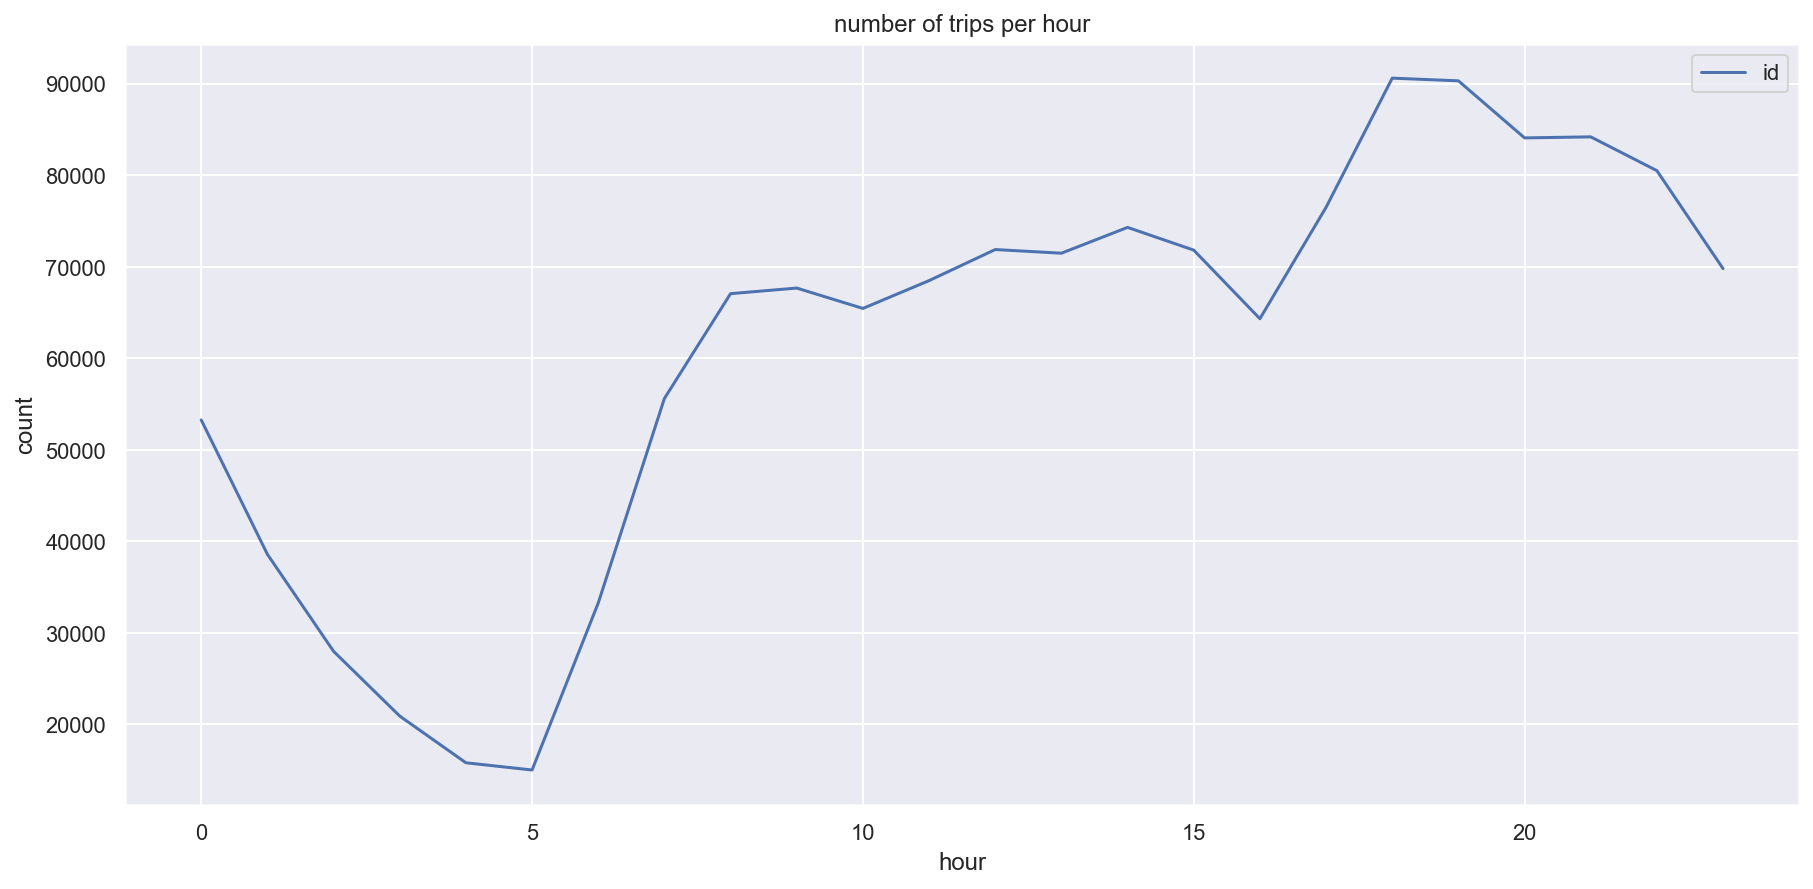

In [25]:
data.apply({'pickup_datetime': lambda x: x.hour, 'log_trip_duration':lambda x: x}).groupby('pickup_datetime').agg({'log_trip_duration':'mean'}).plot()
plt.title('mean log trip duration per hour')
plt.xlabel('hour')
plt.ylabel('mean log trip duration (min)')

data.apply({'pickup_datetime': lambda x: x.hour, 'id':lambda x: x}).groupby('pickup_datetime').agg({'id':'count'}).plot()
plt.title('number of trips per hour')
plt.xlabel('hour')
plt.ylabel('count')

Text(0, 0.5, 'num of trip')

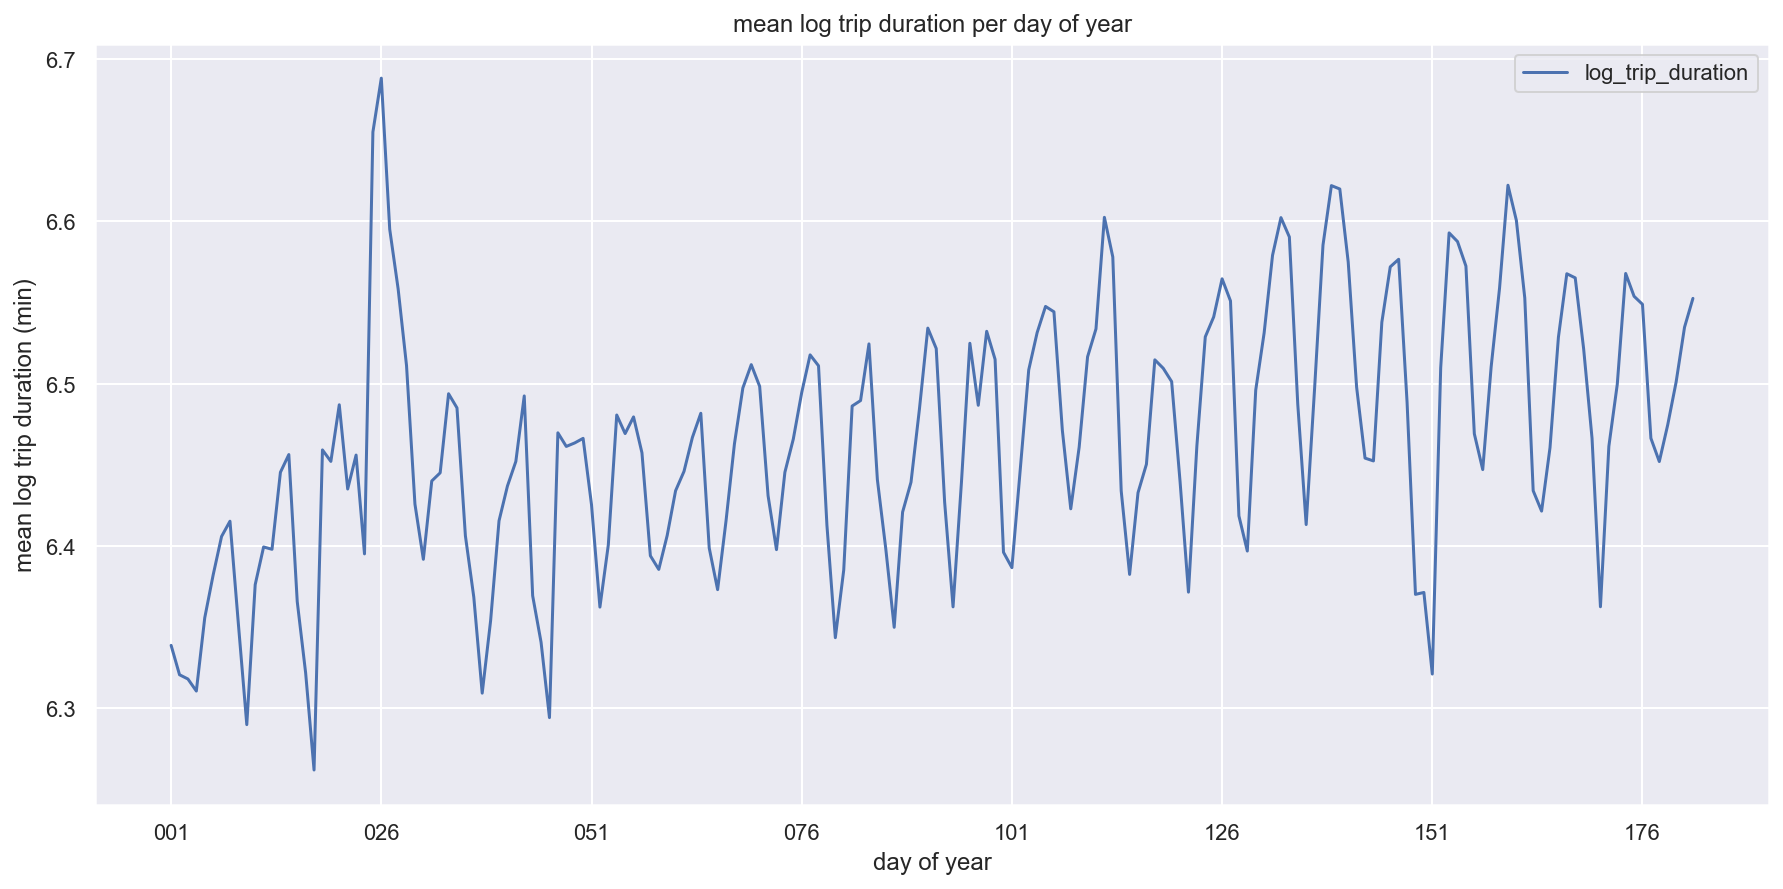

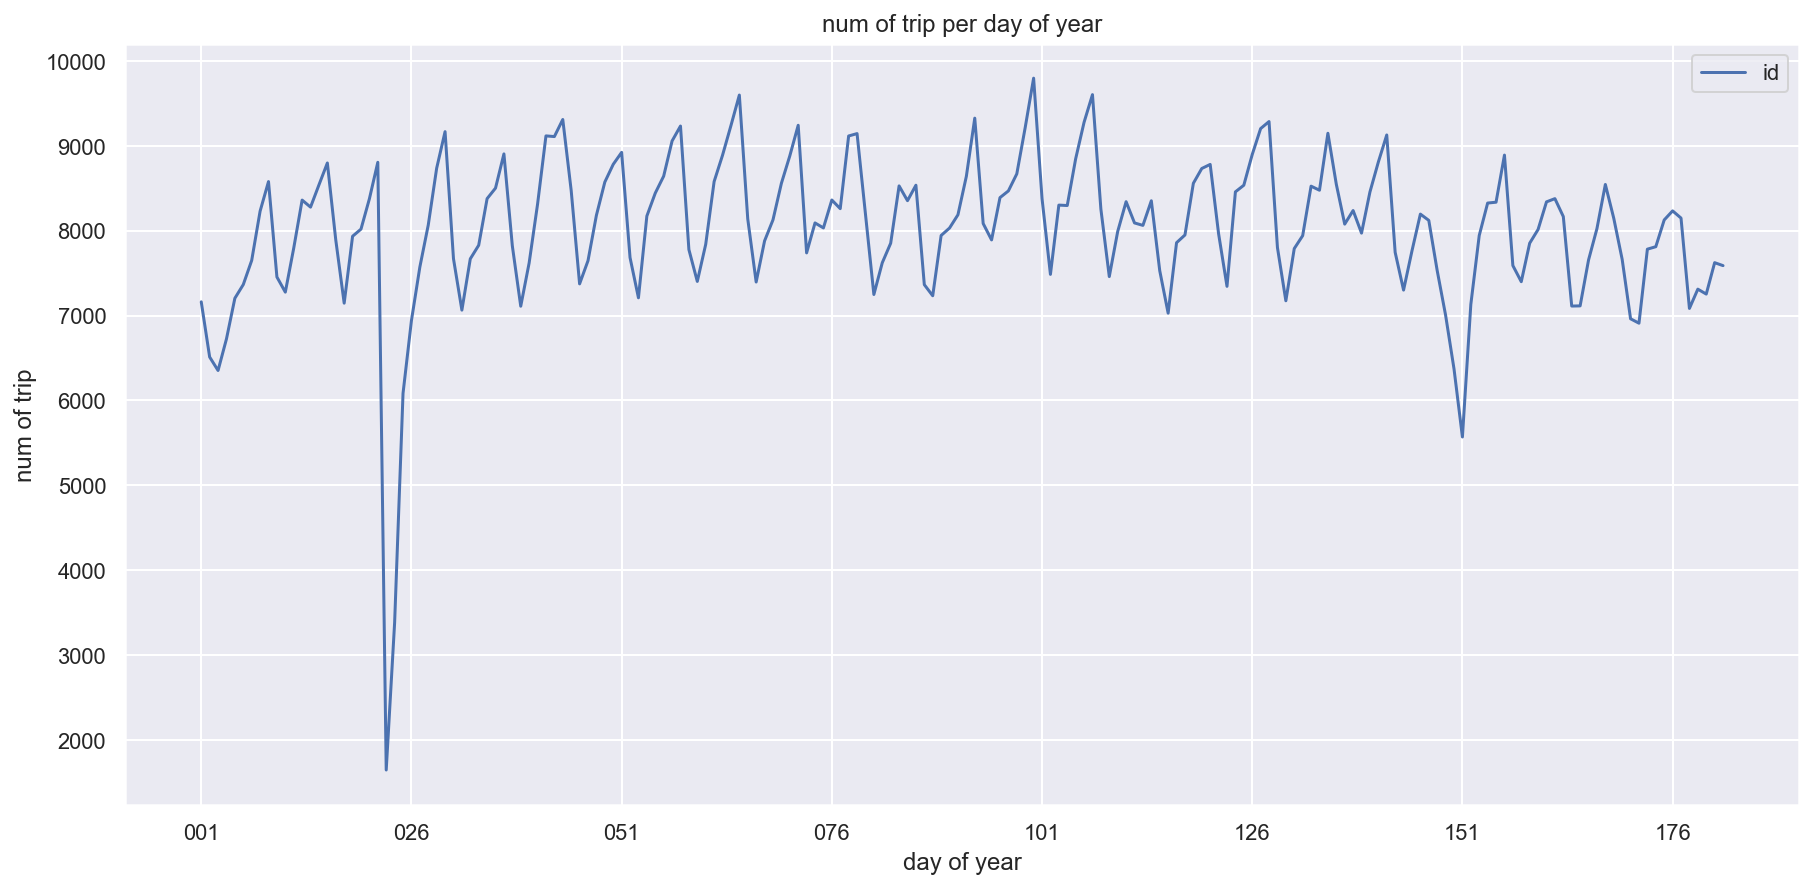

In [26]:
data.apply({'pickup_datetime': lambda x: x.strftime('%j'), 'log_trip_duration':lambda x: x}).groupby('pickup_datetime').agg({'log_trip_duration':'mean'}).plot()
plt.title('mean log trip duration per day of year')
plt.xlabel('day of year')
plt.ylabel('mean log trip duration (min)')

data.apply({'pickup_datetime': lambda x: x.strftime('%j'), 'id':lambda x: x}).groupby('pickup_datetime').agg({'id':'count'}).plot()
plt.title('num of trip per day of year')
plt.xlabel('day of year')
plt.ylabel('num of trip')

Как видно графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок похожи, происходит это потому, что таргет скореллирован с количеством поездок. На графиках наблюдается тренд

Добавим следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным
5. Номер дня в году

In [27]:
#data['pickup_hour'] = data.pickup_datetime.apply(lambda x: x.hour)
data['pickup_weekday'] = data.pickup_datetime.apply(lambda x: x.strftime("%A"))
data['pickup_month'] = data.pickup_datetime.apply(lambda x: x.strftime("%B"))
data['pickup_hour'] = data.pickup_datetime.apply(lambda x: x.hour) 
data['pickup_day'] = data.pickup_datetime.apply(lambda x: x.timetuple().tm_yday)
data['is_anomal_1'] = data.pickup_datetime.apply(lambda x: str(x.date())) == '2016-01-23'
data['is_anomal_2'] = data.pickup_datetime.apply(lambda x: str(x.date())) == '2016-05-30'

#date

Такое разбиение признаков на категориальные и численные 

In [28]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
log_trip_duration            float64
pickup_weekday                object
pickup_month                  object
pickup_hour                    int64
pickup_day                     int64
is_anomal_1                     bool
is_anomal_2                     bool
dtype: object

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

y = data["log_trip_duration"]
X = data[['pickup_weekday', 'pickup_month', 'pickup_hour', 'pickup_day', 'is_anomal_1', 'is_anomal_2']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

categorical = list(X_train.dtypes[X_train.dtypes != 'int64'].index)
numeric = list(X_train.dtypes[X_train.dtypes == "int64"].index)

In [30]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.794532
Train RMSE = 0.791696


In [31]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.7936
	-0.7916
	-0.7939
	-0.7939
	-0.7874
	-0.7943
	-0.7884
	-0.7886
	-0.7964
	-0.7889
Mean CV RMSE = 0.7917


In [32]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [33]:
show_circles_on_map(data.sample(100), "pickup_latitude", "pickup_longitude", "blue")

In [34]:
show_circles_on_map(data.sample(100), "dropoff_latitude", "dropoff_longitude", "blue")

In [35]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'pickup_weekday', 'pickup_month', 'pickup_hour', 'pickup_day',
       'is_anomal_1', 'is_anomal_2'],
      dtype='object')

In [36]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))  
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


data['haversine'] = haversine(data.pickup_longitude, data.pickup_latitude, data.dropoff_longitude, data.dropoff_latitude)

In [37]:
data['log_haversine'] = np.log1p(data['haversine'])

In [38]:
np.corrcoef([data.log_haversine, data.log_trip_duration])[0,1]

0.7498822373942495

In [39]:
np.corrcoef([data.haversine, data.log_trip_duration])[0, 1]

0.5735948311180146

In [40]:
np.exp(np.log(9911231220))

9911231220.000013

In [41]:
X_train['velocity'] = data.haversine[X_train.index] / np.exp(data.log_trip_duration[X_train.index]) * 3600 #kmph

Text(0, 0.5, 'count')

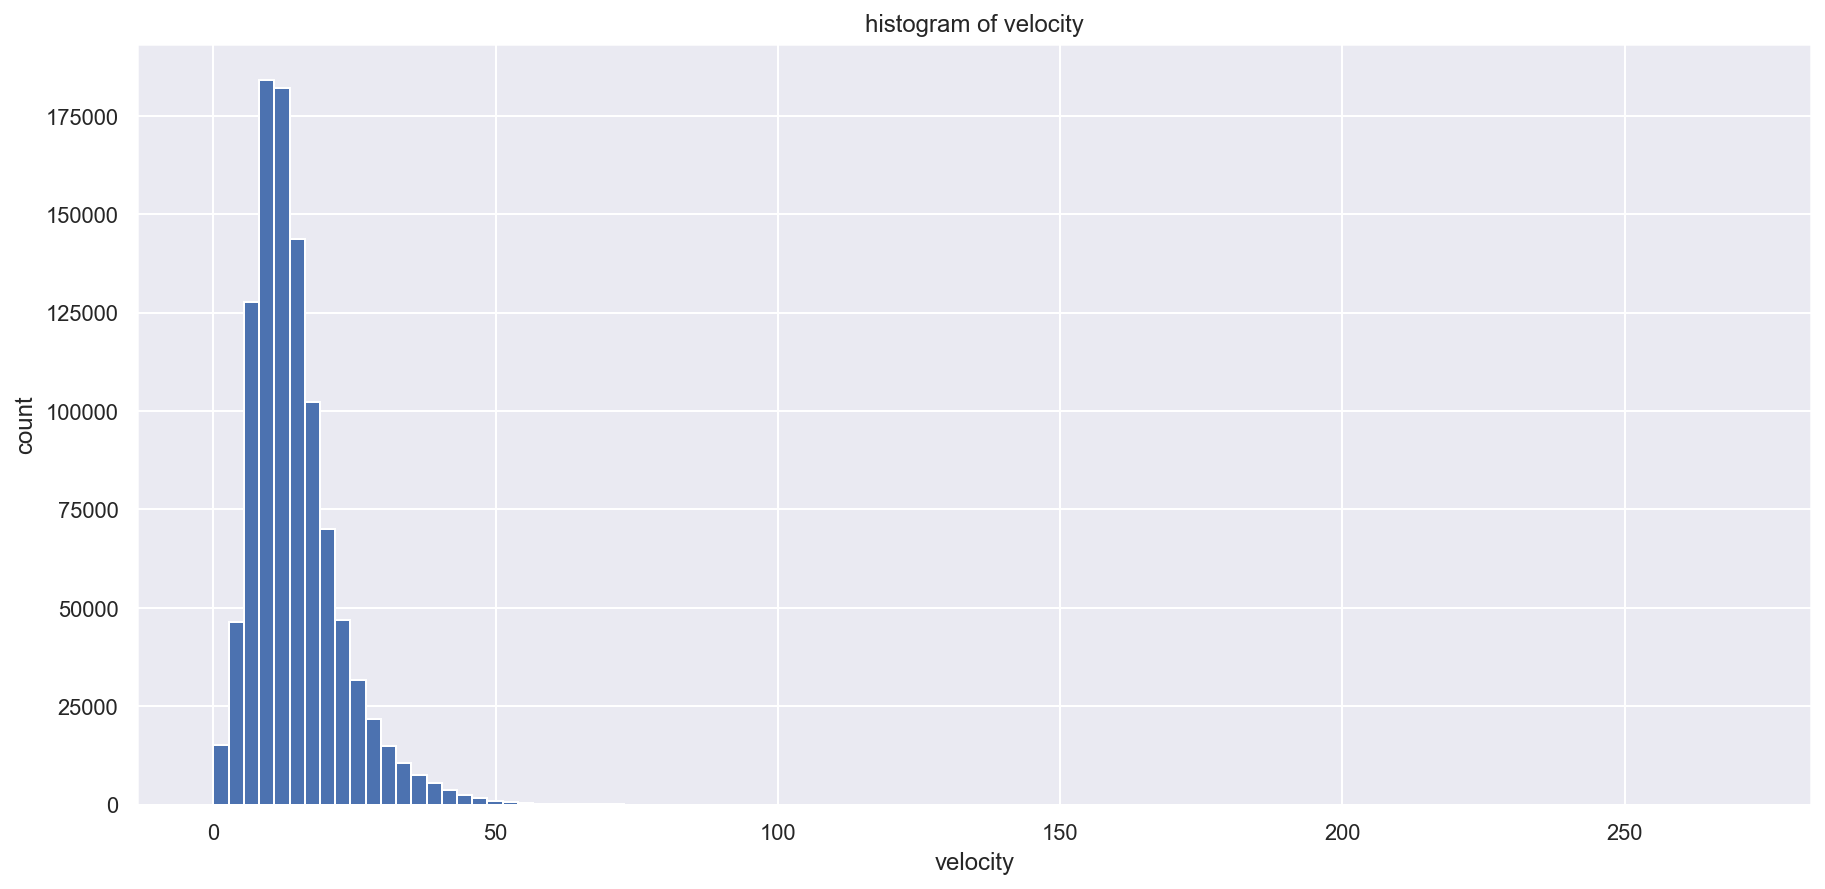

In [42]:
X_train.velocity[X_train.velocity < 300].hist(bins = 100)
plt.title('histogram of velocity')
plt.xlabel('velocity')
plt.ylabel('count')


<AxesSubplot:xlabel='pickup_hour', ylabel='pickup_weekday'>

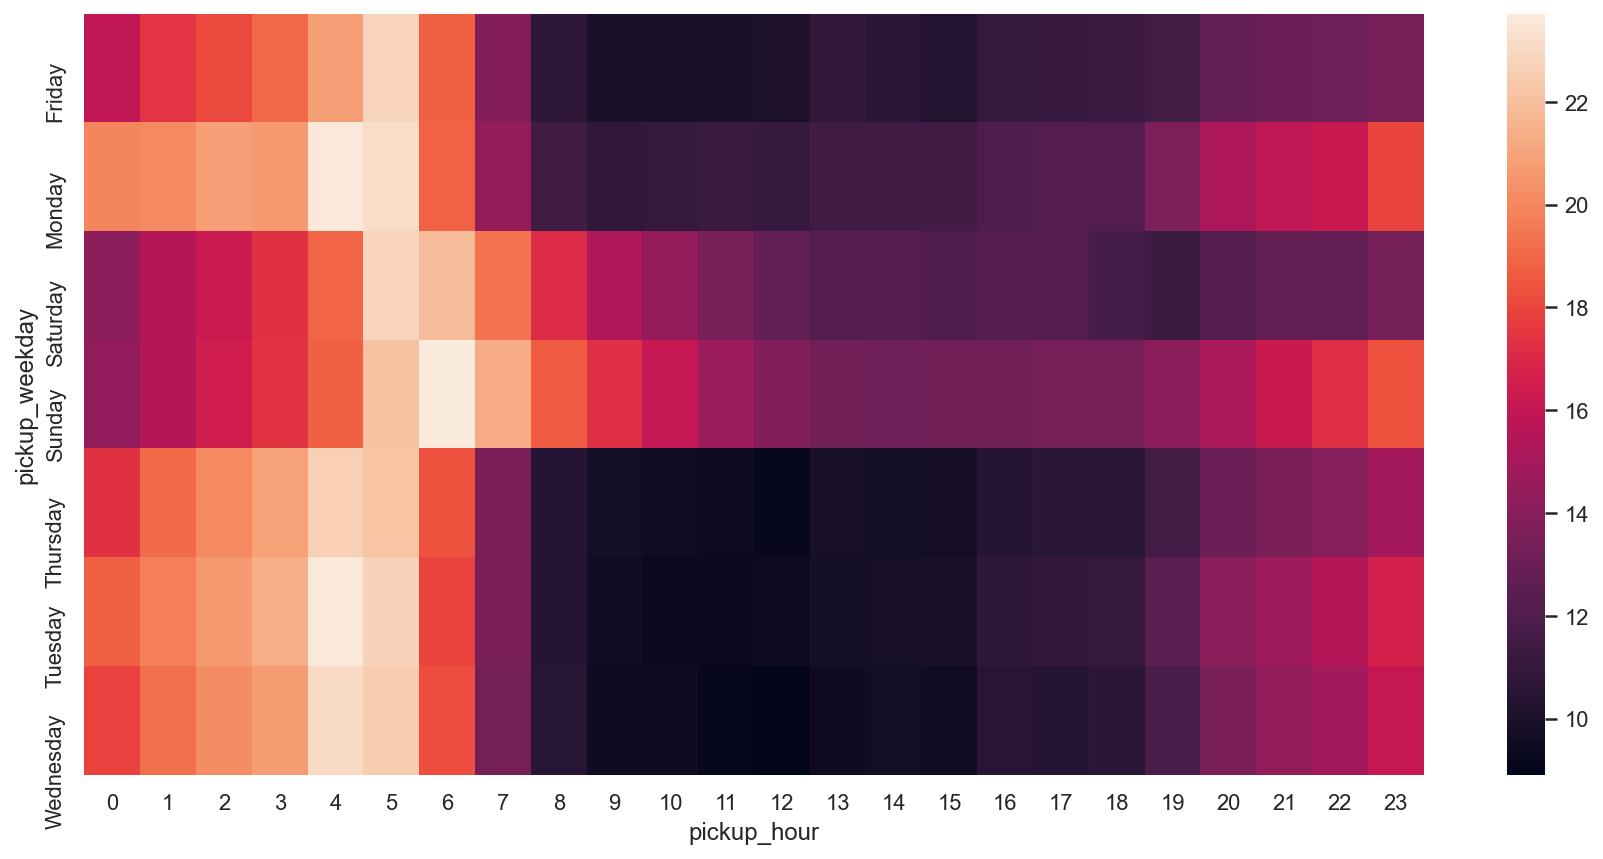

In [44]:
sns.heatmap(X_train[['pickup_weekday', 'pickup_hour', 'velocity']].groupby(by=['pickup_weekday', 'pickup_hour']).velocity.median().unstack())

In [45]:
#X_train[['pickup_weekday', 'pickup_hour', 'velocity']].groupby(by=['pickup_weekday', 'pickup_hour']).velocity.median().unstack()

In [47]:
data['is_traffic_jam'] = (data.pickup_hour >= 8) & (data.pickup_hour <= 15) & ((data.pickup_weekday == 'Wednesday') | (data.pickup_weekday == 'Tuesday') | (data.pickup_weekday == 'Thursday') | (data.pickup_weekday == 'Friday'))
data['is_free_roads'] = (data.pickup_hour >= 0) & (data.pickup_hour <= 6)

In [48]:
for airport in ['jk_', 'lg_','nlia_']:
    for status in ['dropoff', 'pickup']:
        if airport == 'jk_':
            lat1 = 40.63
            lat2 = 40.67
            lon1 = -73.81
            lon2 = -73.76
        elif airport == 'lg_':
            lat1 = 40.77
            lat2 = 40.78
            lon1 = -73.89
            lon2 = -73.86
        else:
            lat1 = 40.65
            lat2 = 40.71
            lon1 = -74.20
            lon2 = -74.14
        vec = data[(data[status + '_latitude'] > lat1)&(data[status + '_longitude'] > lon1)&
        (data[status + '_latitude'] < lat2)&(data[status + '_longitude'] < lon2)]
        data['is_' + airport + status] = pd.Series(np.ones(vec.shape[0]), vec.index)
data.fillna(0, inplace = True)

In [49]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'pickup_weekday', 'pickup_month', 'pickup_hour', 'pickup_day',
       'is_anomal_1', 'is_anomal_2', 'haversine', 'log_haversine',
       'is_traffic_jam', 'is_free_roads', 'is_jk_dropoff', 'is_jk_pickup',
       'is_lg_dropoff', 'is_lg_pickup', 'is_nlia_dropoff', 'is_nlia_pickup'],
      dtype='object')

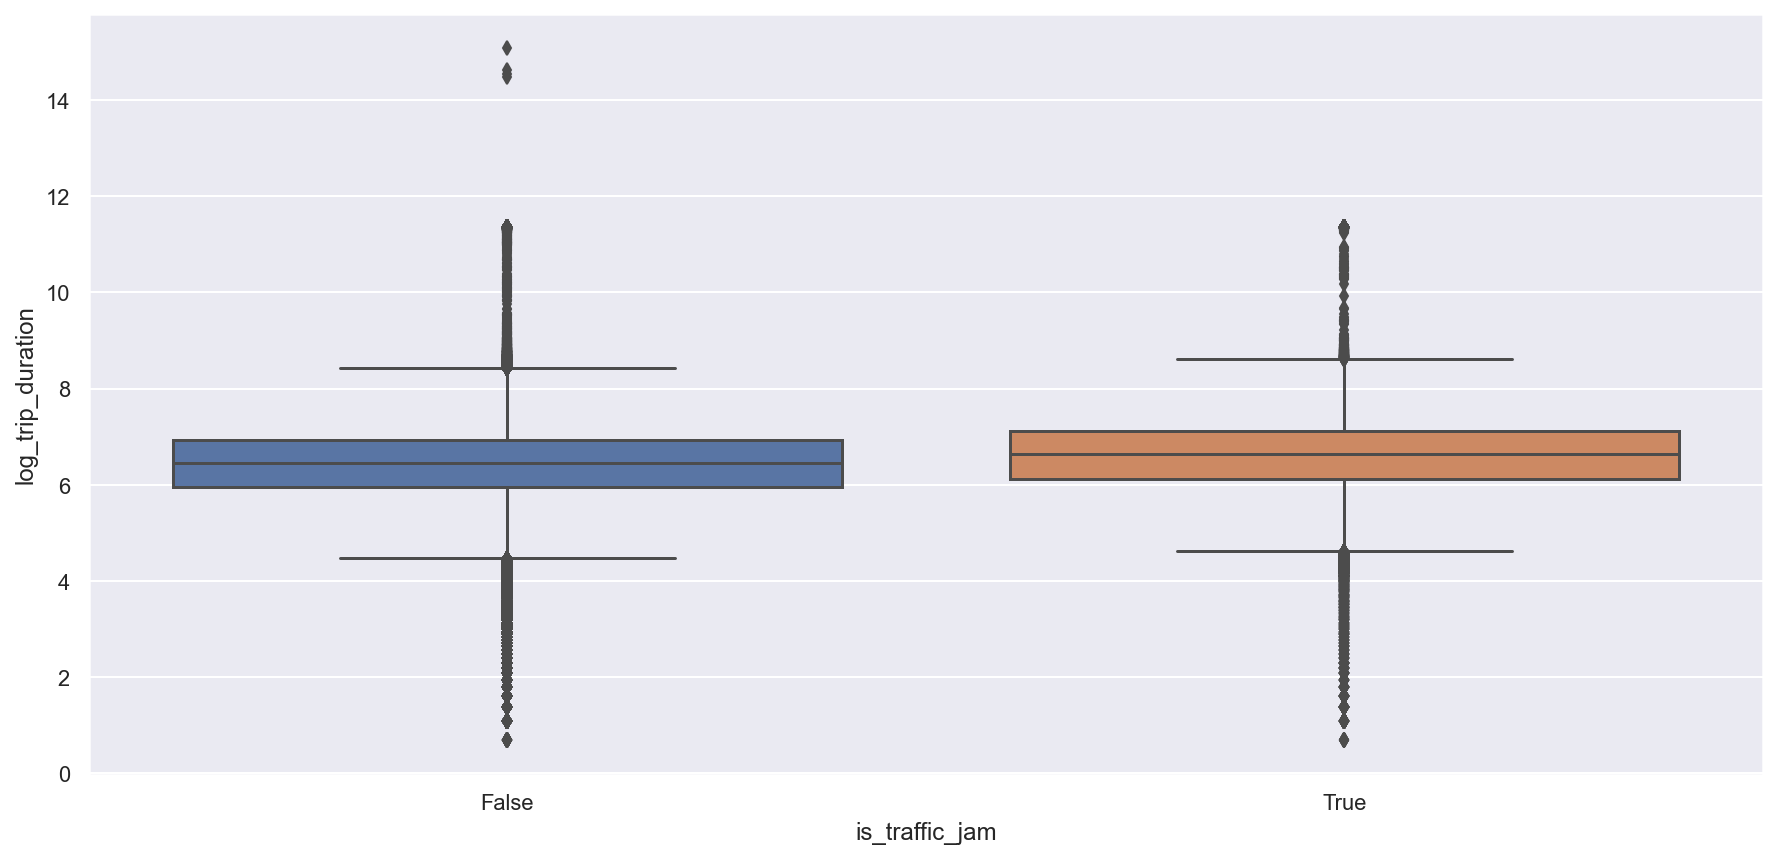

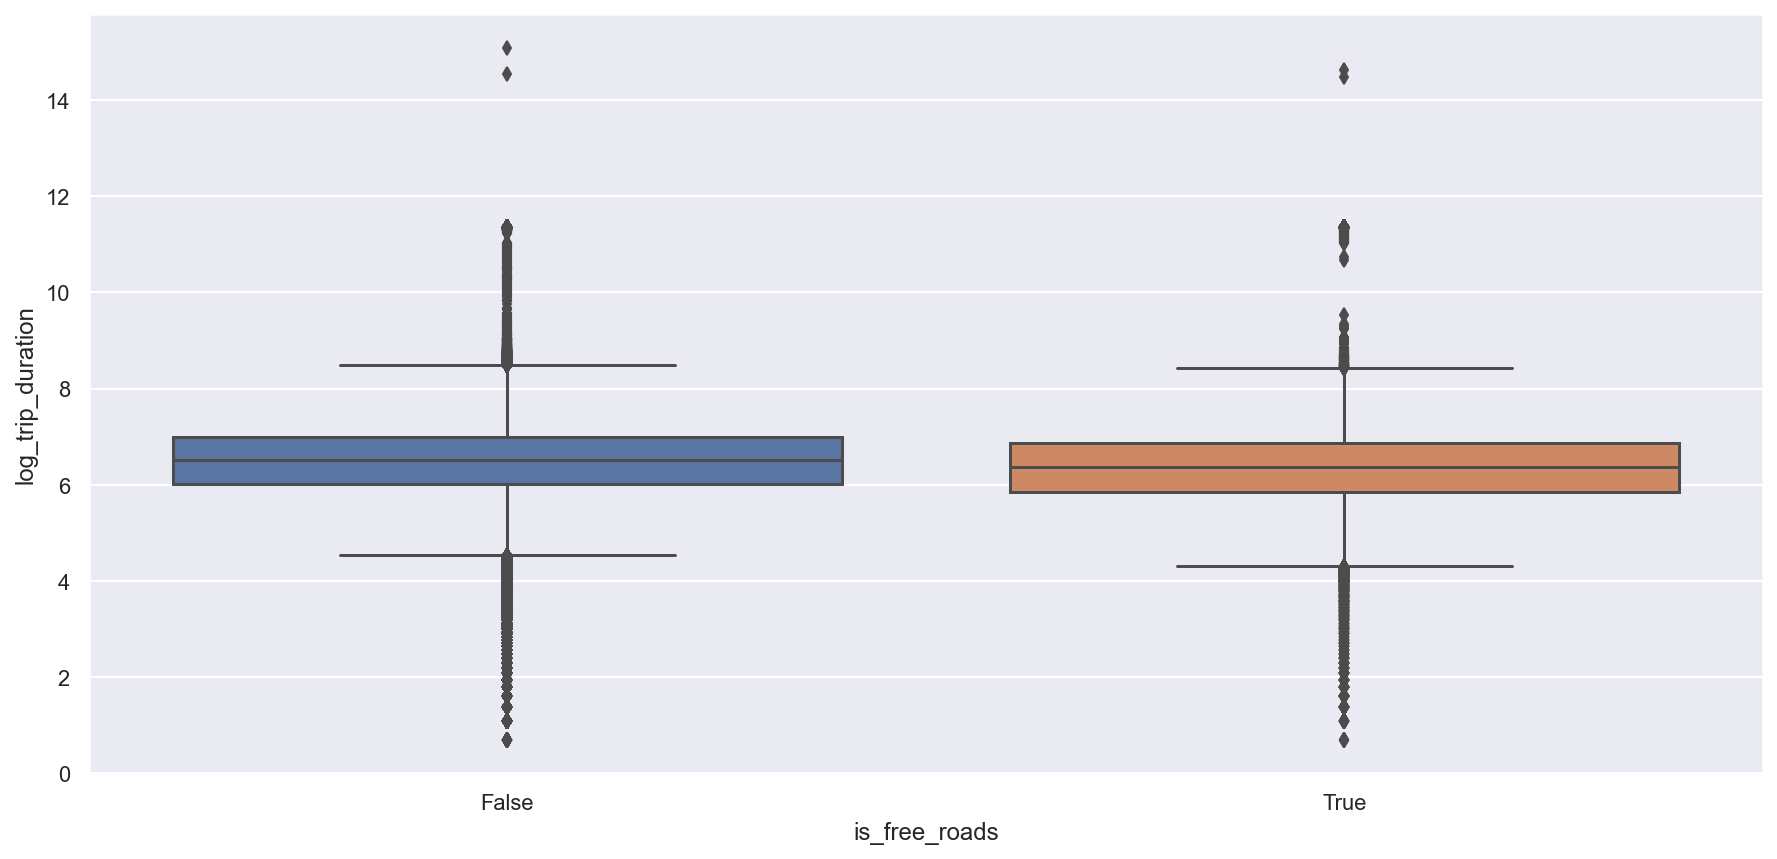

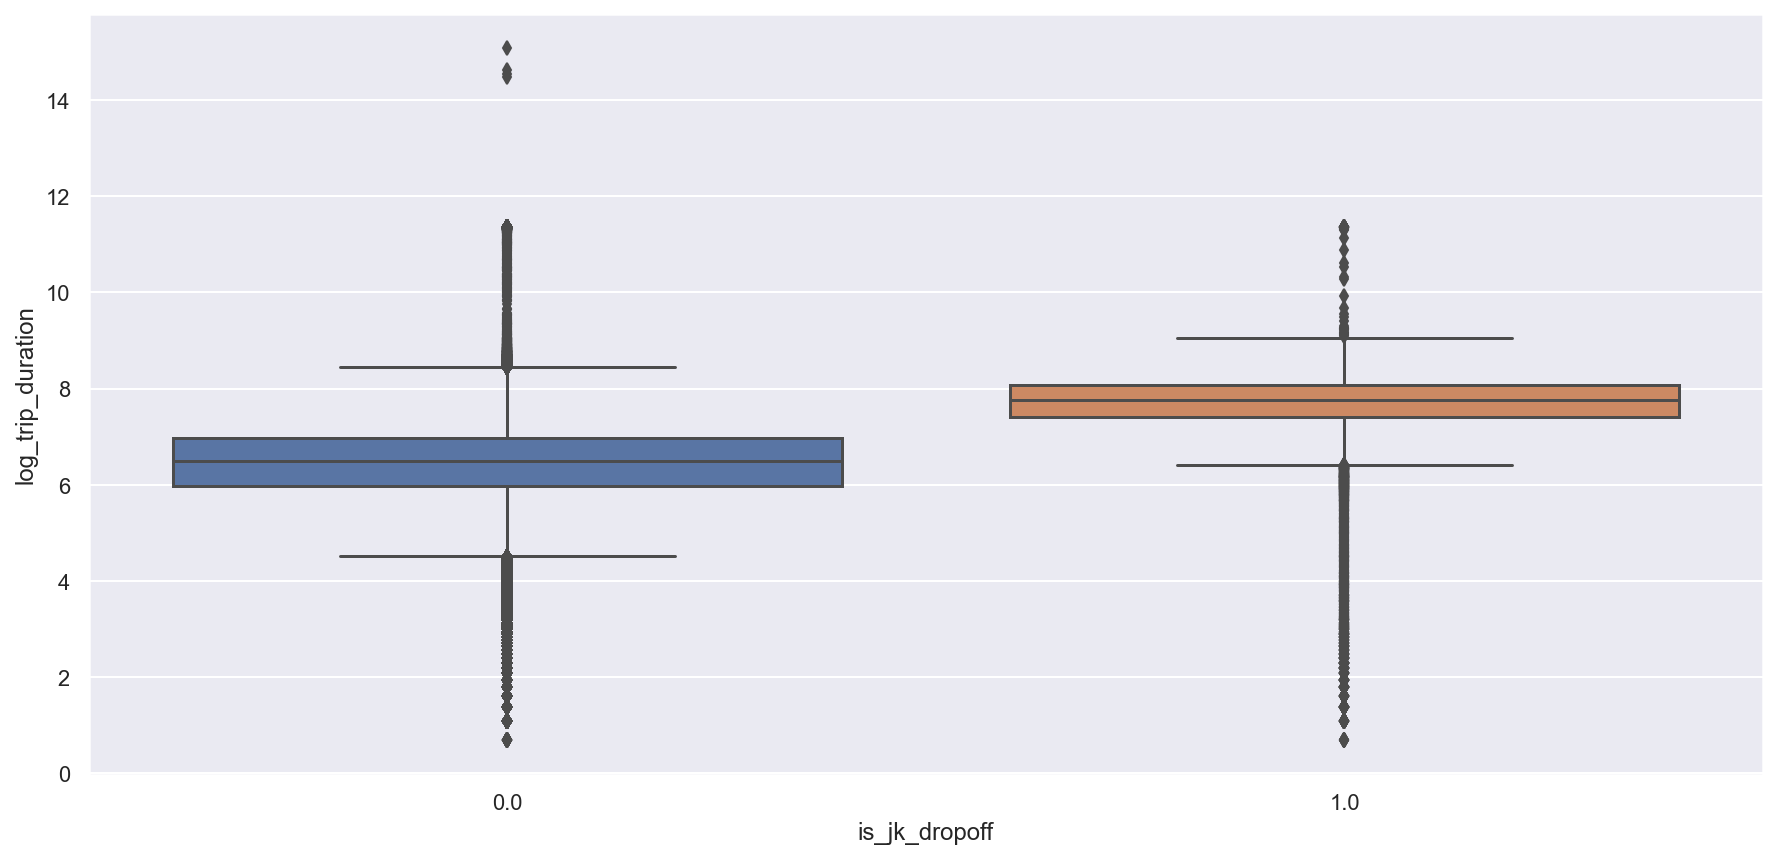

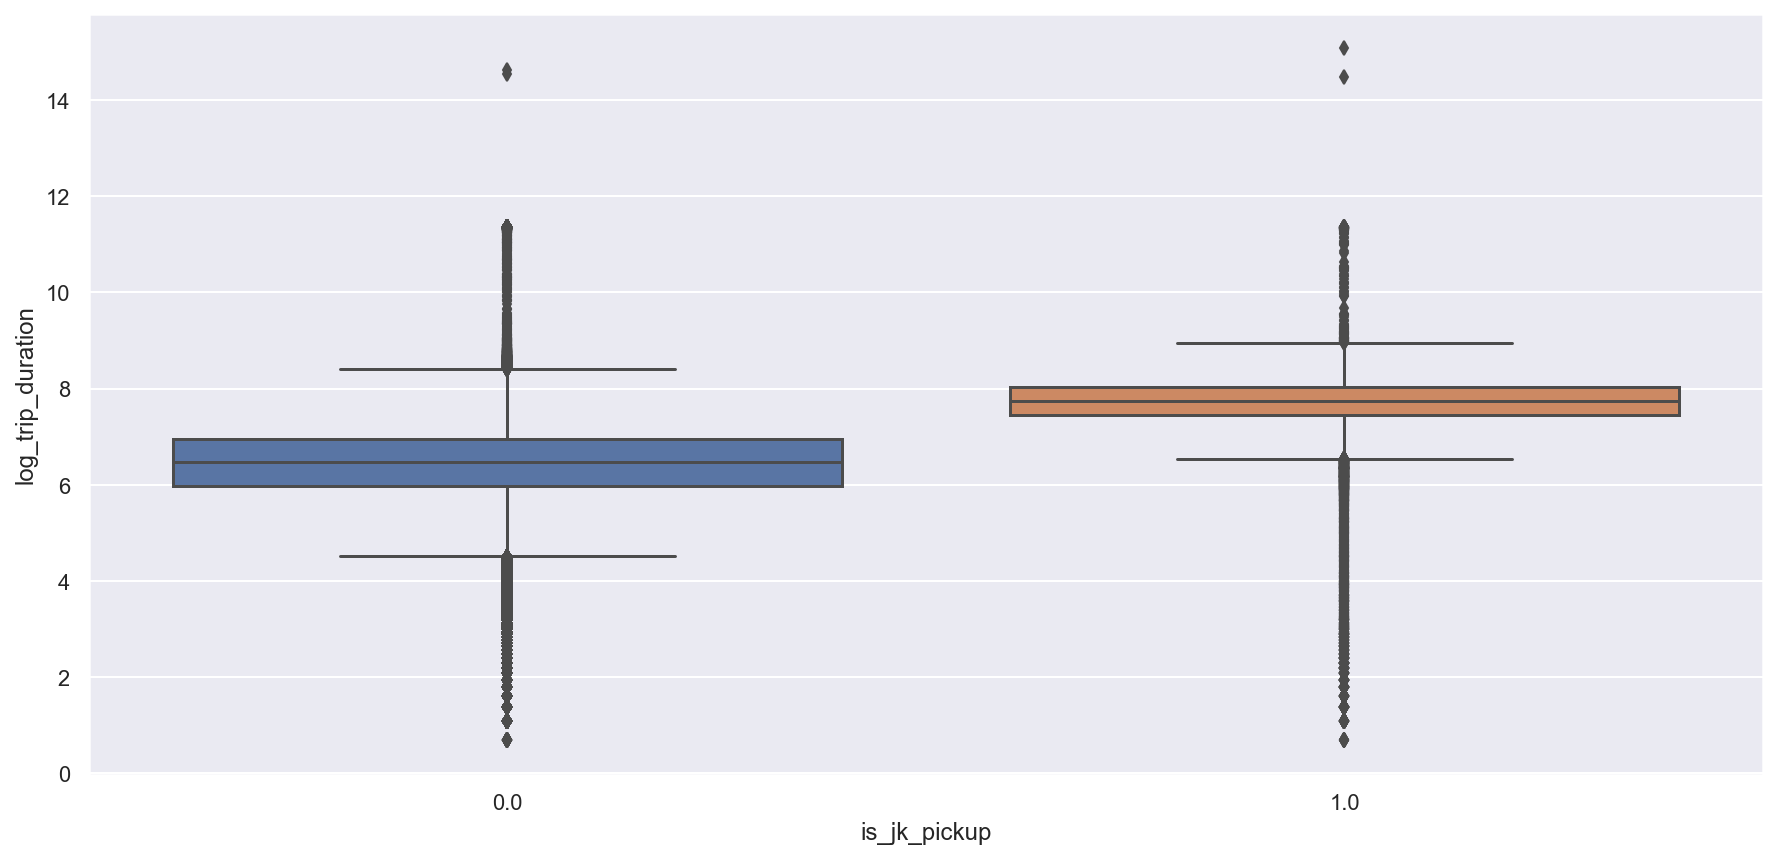

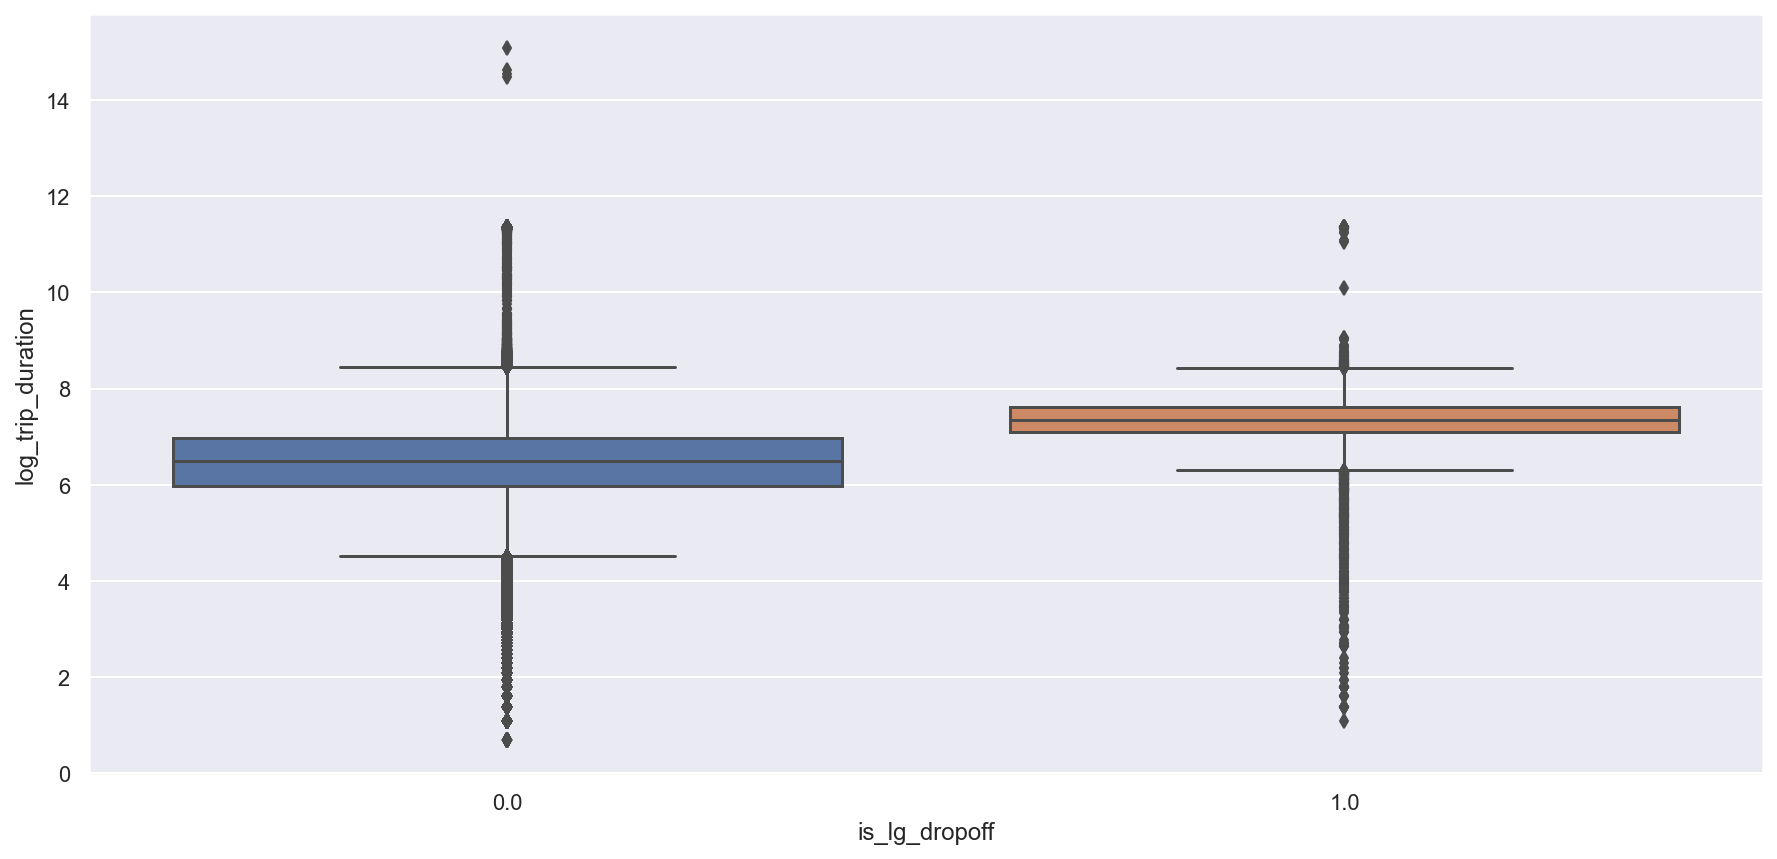

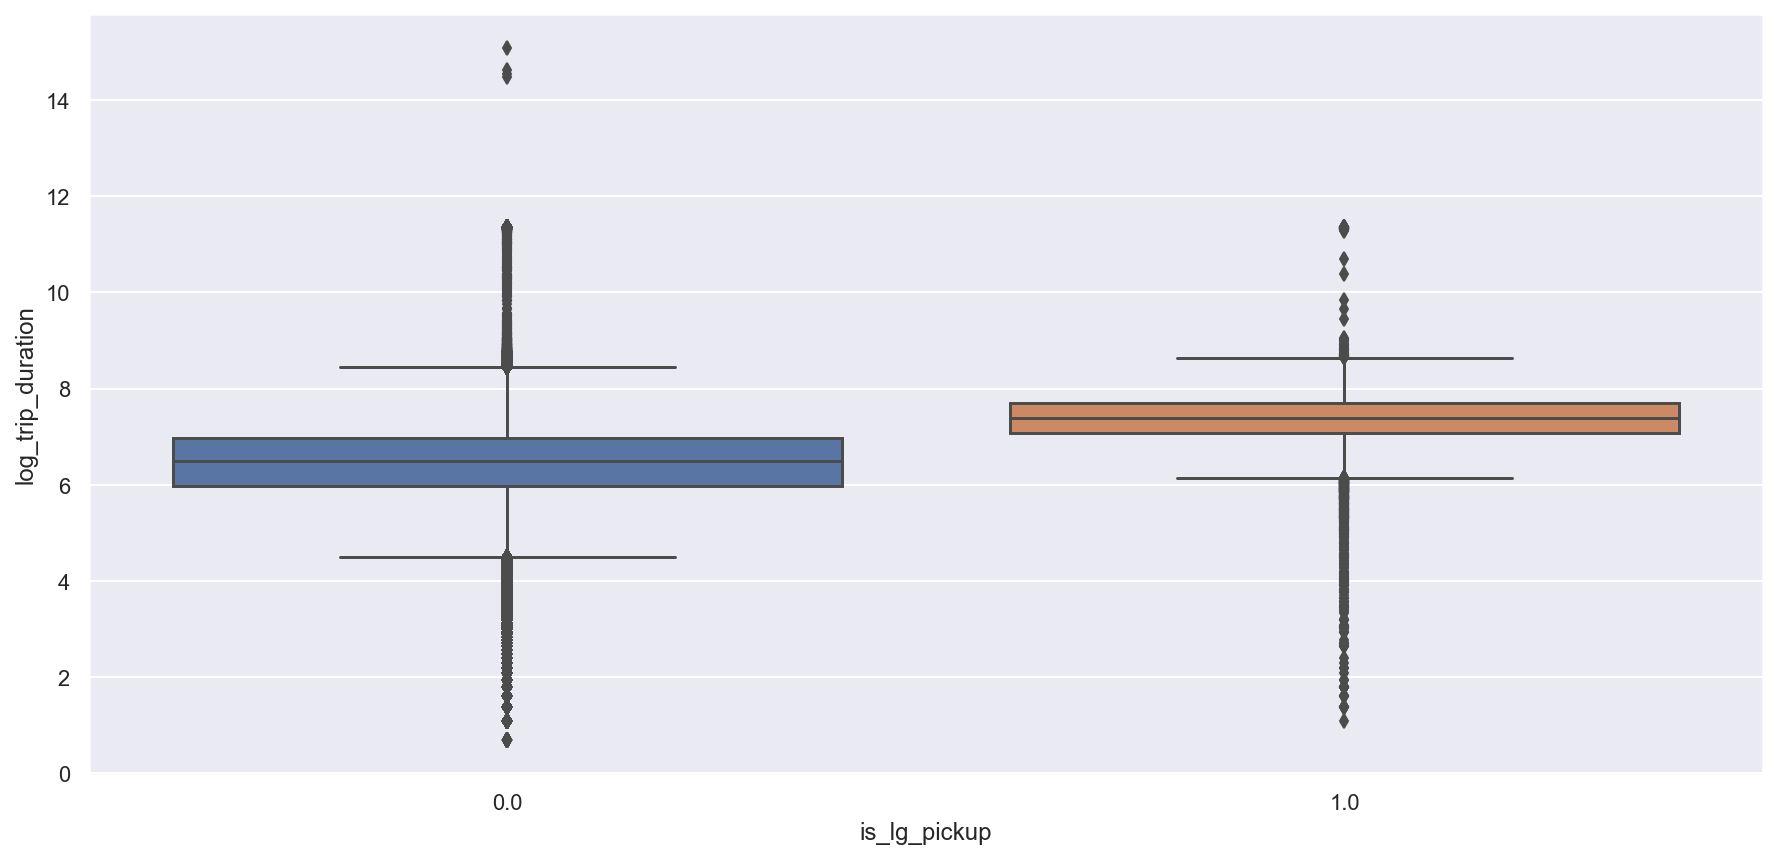

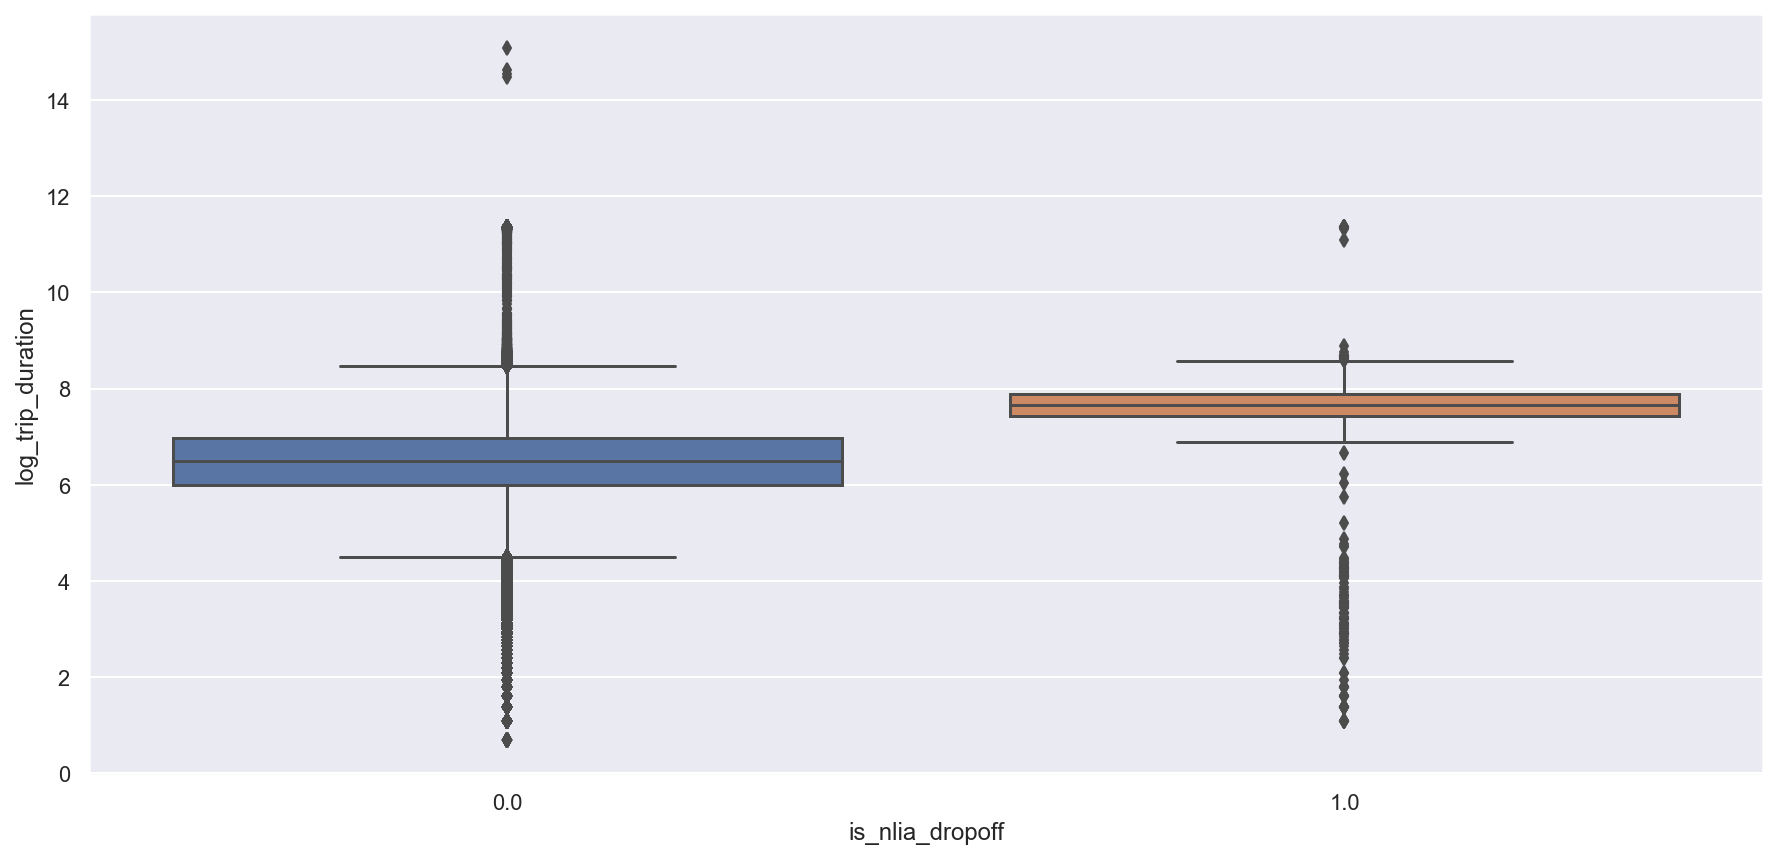

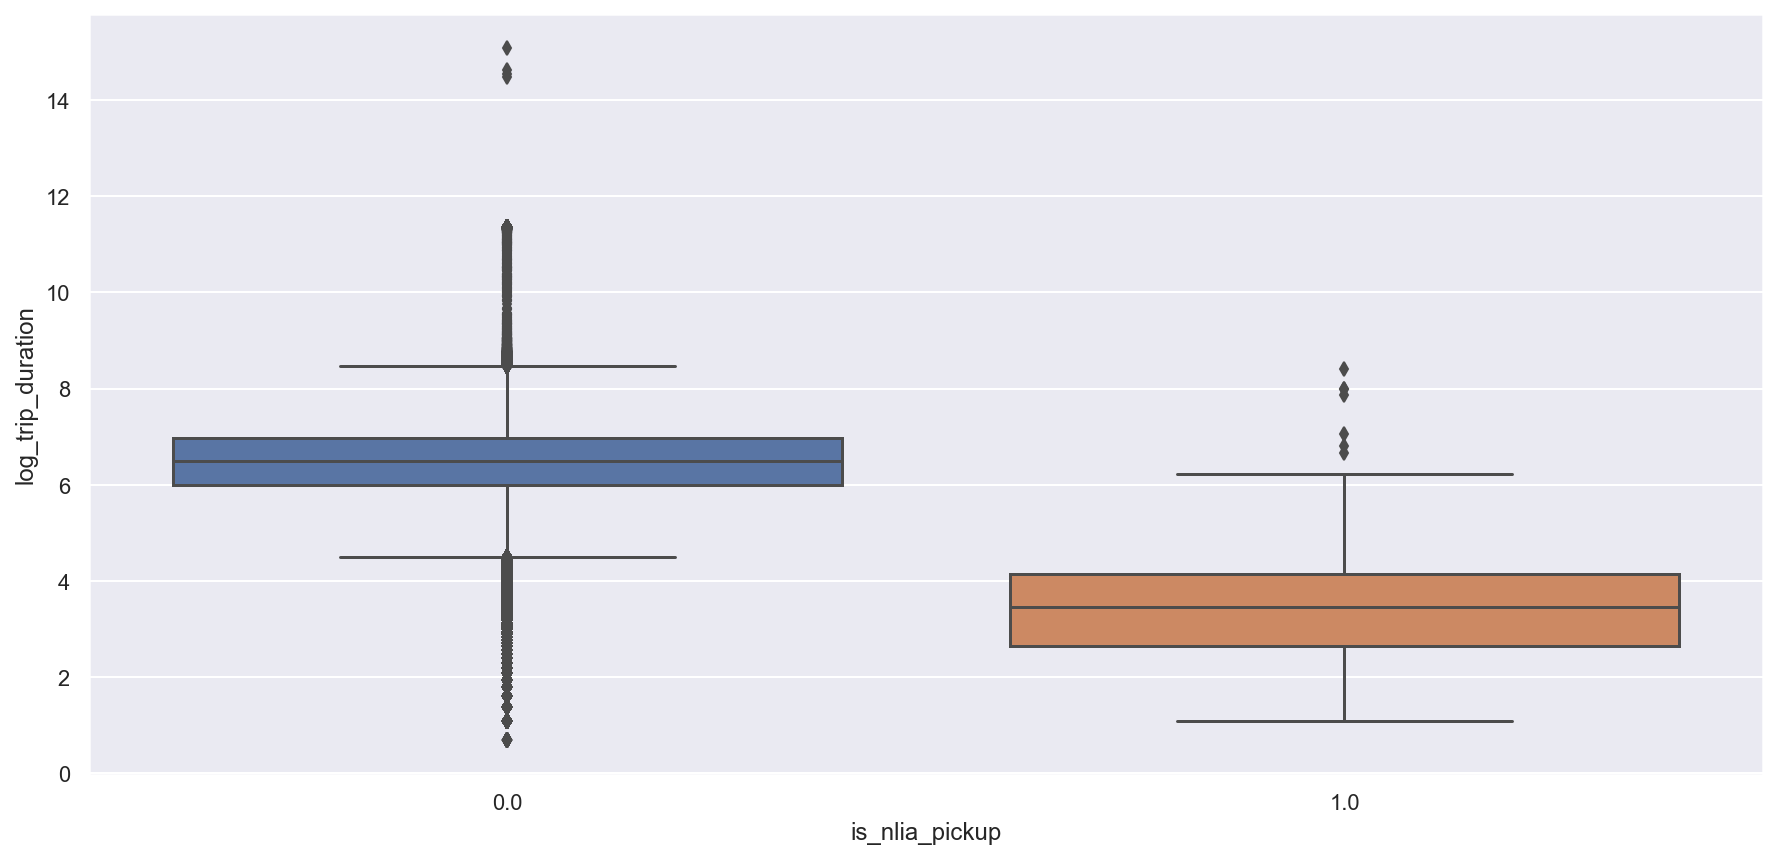

In [50]:
for el in ['is_traffic_jam', 'is_free_roads', 'is_jk_dropoff', 'is_jk_pickup', 'is_lg_dropoff', 'is_lg_pickup', 'is_nlia_dropoff', 'is_nlia_pickup']:
    sns.boxplot(data=data, y = 'log_trip_duration', x = el)
    plt.show()

In [51]:
data['is_airport_dropoff'] = data['is_nlia_dropoff'] + data['is_jk_dropoff'] + data['is_lg_dropoff']
data['is_airport_pickup'] = data['is_nlia_pickup'] + data['is_jk_pickup'] + data['is_lg_pickup']
data.drop(columns = ['is_nlia_pickup', 'is_jk_pickup', 'is_lg_pickup', 'is_nlia_dropoff', 'is_jk_dropoff', 'is_lg_dropoff'], inplace = True)

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, quantile=0.95, n_l=20, n_w = 20):
        """
        Функция для разбиения карты на ячейки
        :param quantile: float от 0 до 1, квантиль того, сколько обучающей выборки хотим обрезать для определения области обрамляющего прямоугольника
        :param n_l: int > 0, число ячеек по долготе
        :param n_l: int > 0, число ячеек по широте
        """
        self.quantile = quantile
        self.n_l = n_l
        self.n_w = n_w
        
    def fit(self, X_train, y_train):
        self.X_train = X_train.copy()
        self.longitude = self.X_train[['pickup_longitude', 'dropoff_longitude']]
        self.latitude = self.X_train[['pickup_latitude', 'dropoff_latitude']]
        self.longitude_1 = self.longitude.quantile(self.quantile).mean()
        self.longitude_2 = self.longitude.quantile(1 - self.quantile).mean()
        self.latitude_1 = self.latitude.quantile(self.quantile).mean()
        self.latitude_2 = self.latitude.quantile(1 - self.quantile).mean()
        return self

    def transform(self, X):
        self.X = X.copy()
        l = np.linspace(self.latitude_2, self.latitude_1, self.n_l)
        w = np.linspace(self.longitude_2, self.longitude_1, self.n_w) 
        for status in ['pickup', 'dropoff']:  
            for coordinate in ['latitude', 'longitude']:
                if coordinate == 'latitude':
                    size = l
                    n = self.n_l
                else:
                    size = w
                    n = self.n_w
                square_coordinate = np.searchsorted(size, self.X[status + '_' + coordinate])
                square_coordinate = np.where((square_coordinate == 0)|
                                             (square_coordinate == n), -1, square_coordinate) 
                self.X['square_' + status + '_' + coordinate] = square_coordinate
            K = self.X[(self.X['square_' + status + '_longitude'] != -1)&(self.X['square_' + status + '_latitude'] != -1)]
            self.X['square_' + status] = (K['square_' + status + '_latitude']
                                           - 1) * self.n_w + K['square_' + status + '_longitude']
            self.X.drop(columns = ['square_' + status + '_longitude', 'square_' + status + '_latitude'], 
                       inplace = True) 
        self.X.fillna(-1, inplace = True)
        return self.X

In [57]:
#data.dtypes

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


X = data.drop(columns = "log_trip_duration")
y = data.log_trip_duration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=137)

numeric_features = ['log_haversine']

categorical = ['pickup_weekday', 'pickup_hour', 'pickup_month',
       'pickup_day', 'is_anomal_1', 'is_anomal_2', 'is_traffic_jam', 'is_airport_dropoff', 'is_airport_pickup', 'square_pickup', 'square_dropoff', 'vendor_id', 'store_and_fwd_flag']

MGT = MapGridTransformer(quantile = 0.997, n_l = 110, n_w = 110)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

#alpha = 150

pipeline = Pipeline(steps=[('map_grid_transformer', MGT),
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha = 100))
    ])

In [63]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.459221
Train RMSE = 0.461213


In [64]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.4640
	-0.4632
	-0.4586
	-0.4673
	-0.4586
	-0.4665
	-0.4624
	-0.4564
	-0.4641
	-0.4632
Mean CV RMSE = 0.4624


In [65]:
remaining_features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
data[remaining_features].nunique()

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

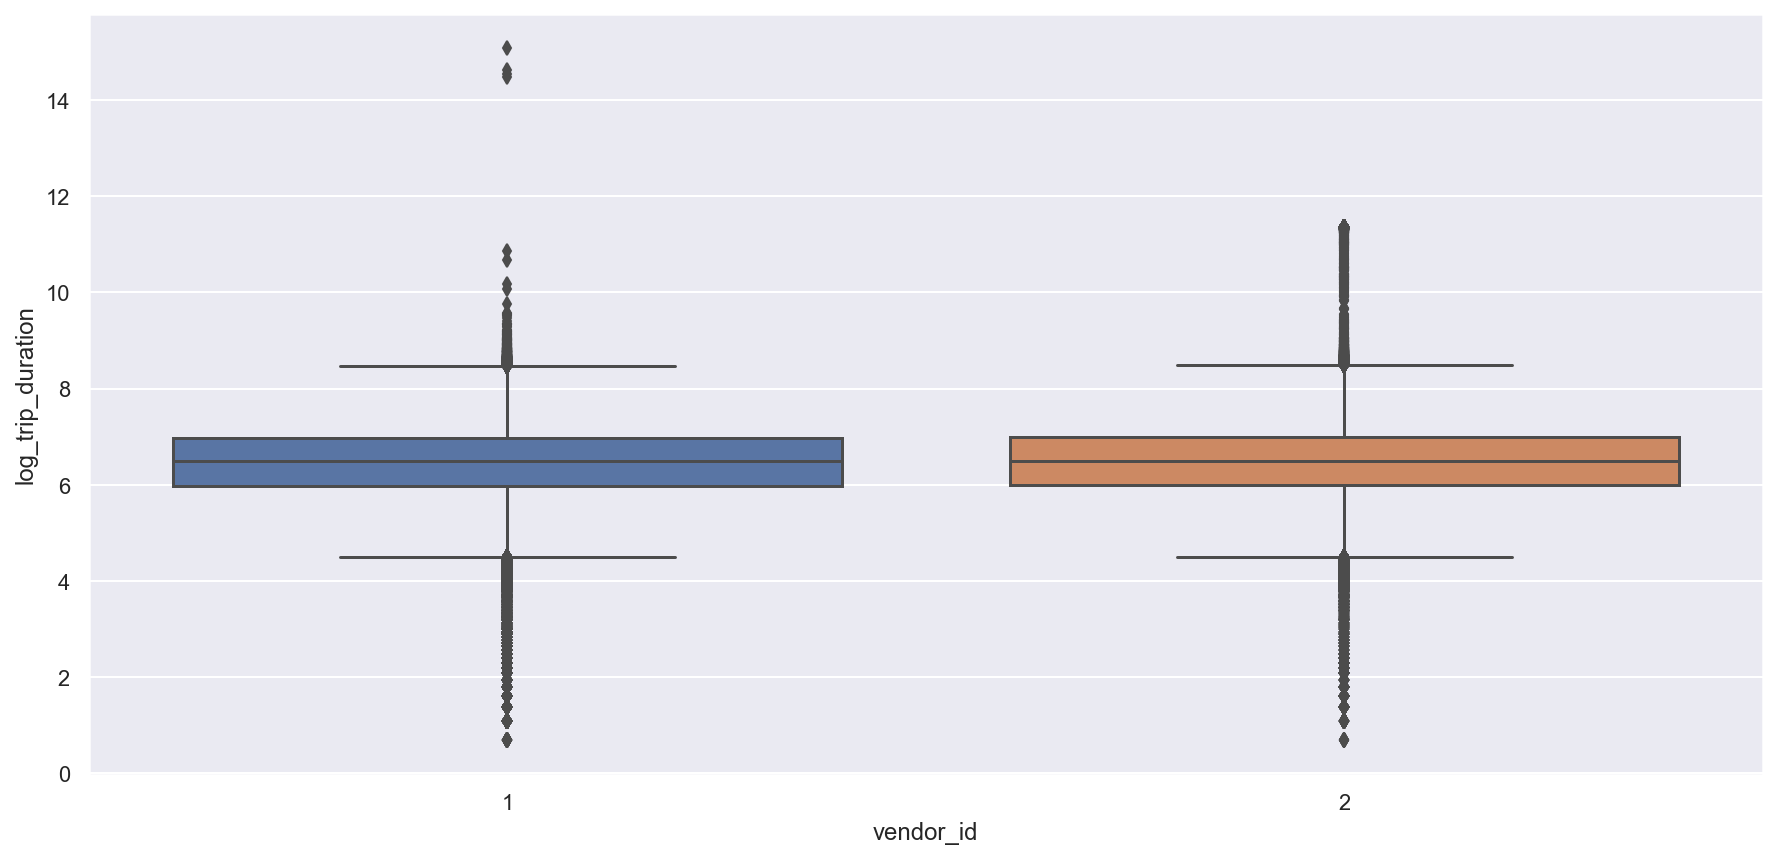

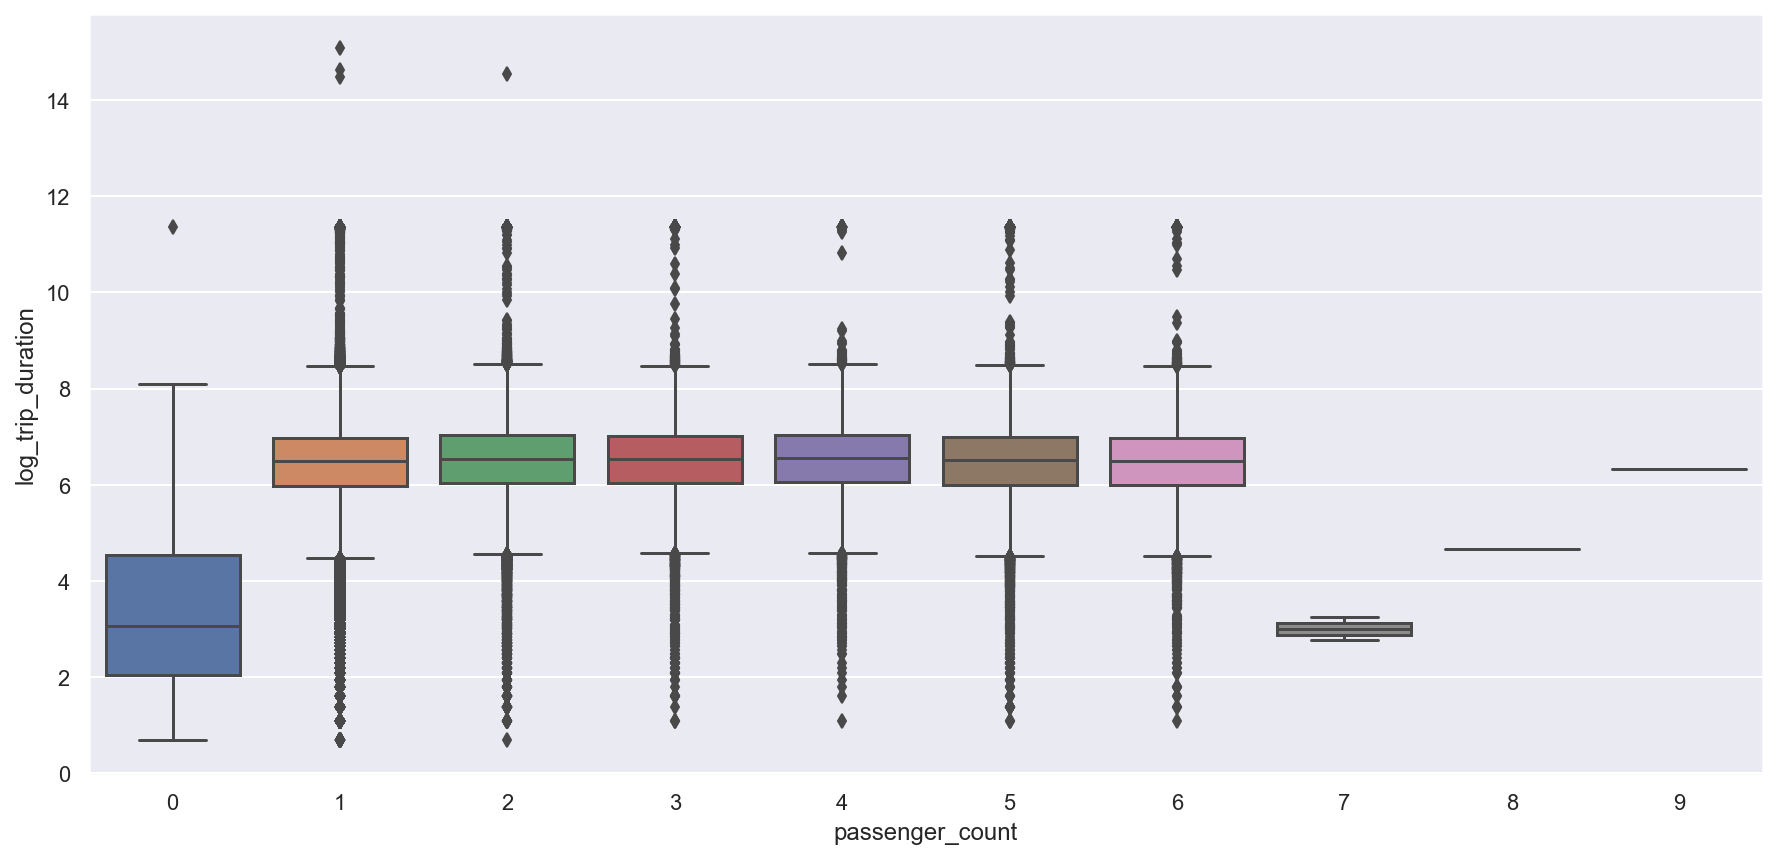

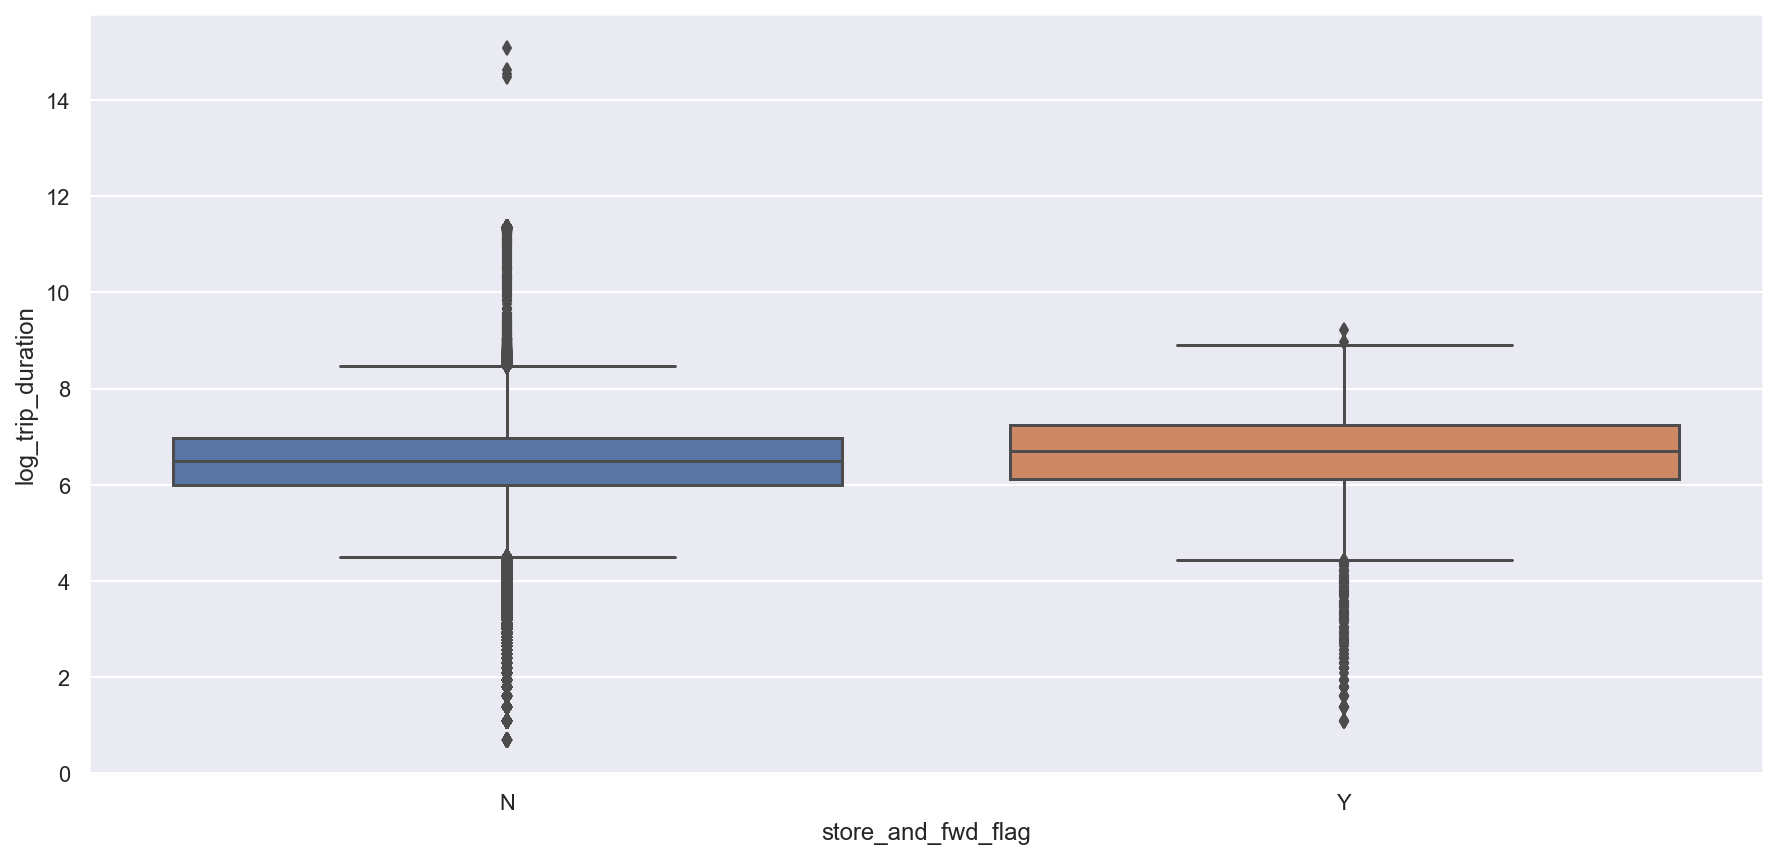

In [66]:
for el in remaining_features:
    sns.boxplot(data=data, y = 'log_trip_duration', x = el)
    plt.show()

In [67]:
data.vendor_id.replace({2: 1,1: 0}, inplace=True)
data.store_and_fwd_flag.replace({'Y': 1,'N': 0}, inplace=True)

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


X = data.drop(columns = "log_trip_duration")
y = data.log_trip_duration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=137)

numeric_features = ['log_haversine']

categorical = ['pickup_weekday', 'pickup_hour', 'pickup_month',
       'pickup_day', 'is_anomal_1', 'is_anomal_2', 'is_traffic_jam', 'is_airport_dropoff', 'is_airport_pickup', 'square_pickup', 'square_dropoff', 'vendor_id', 'store_and_fwd_flag']

MGT = MapGridTransformer(quantile = 0.997, n_l = 110, n_w = 110)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[('map_grid_transformer', MGT),
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha = 150))
    ])

In [69]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.459634
Train RMSE = 0.461687


In [70]:
X_train['log_trip_duration'] = y_train
X_train['residual'] = y_train_pred - y_train

In [71]:
def exclude_outliers(df, column):
    l = df[column].quantile(0.01)
    r = df[column].quantile(0.99)
    return (df[column] <= r) & (df[column] >= l)

In [72]:
columns = ['log_trip_duration', 'log_haversine', 'residual']

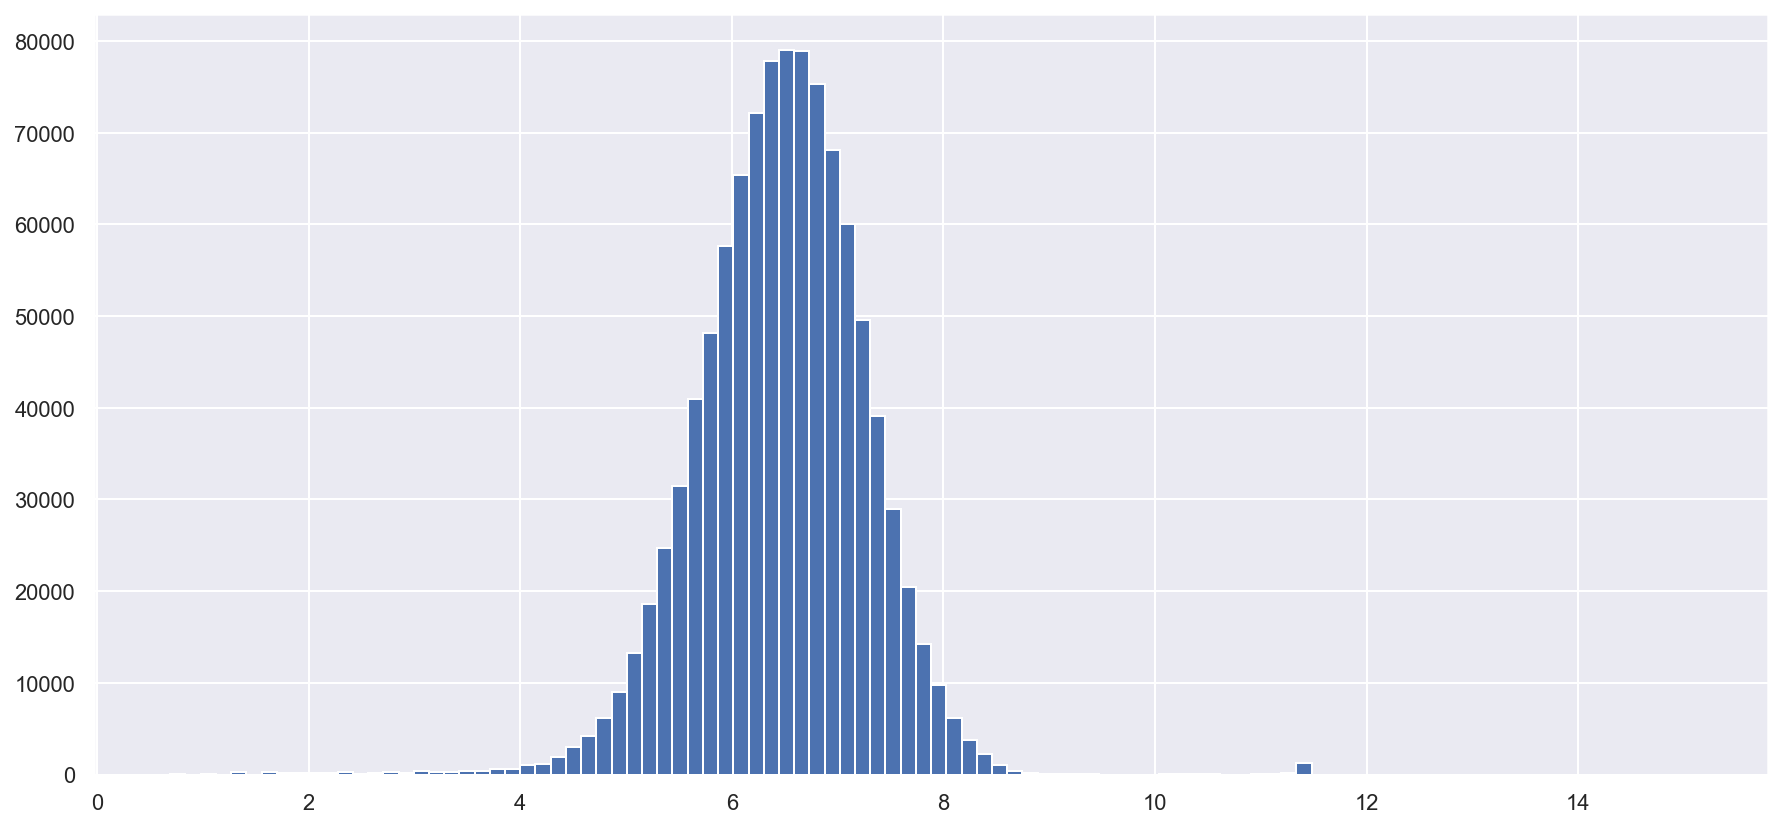

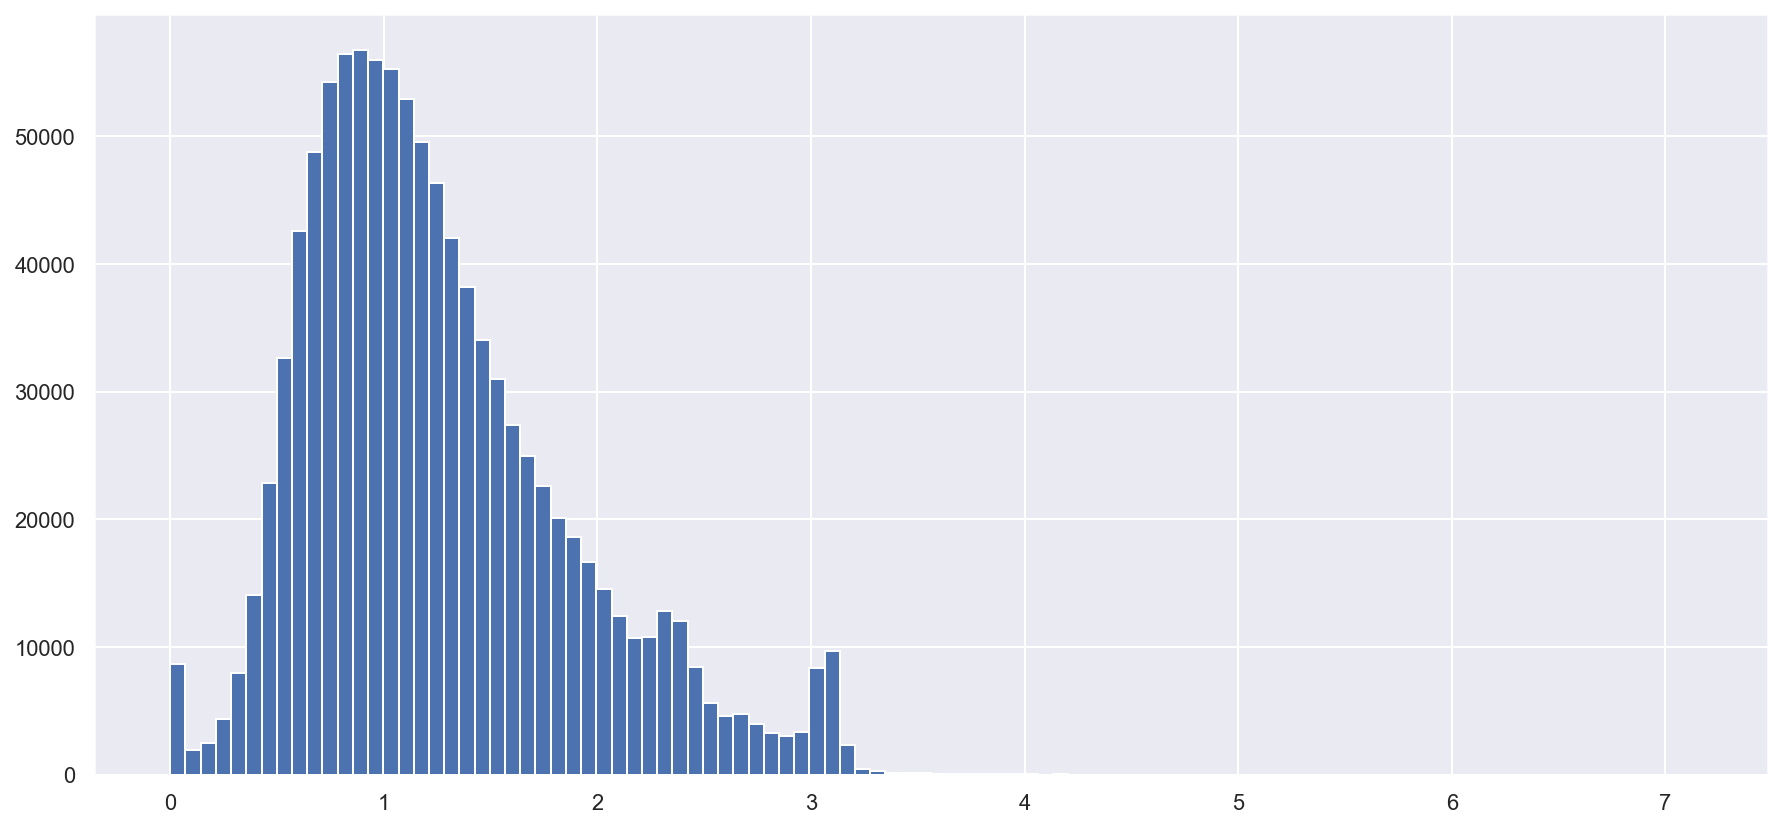

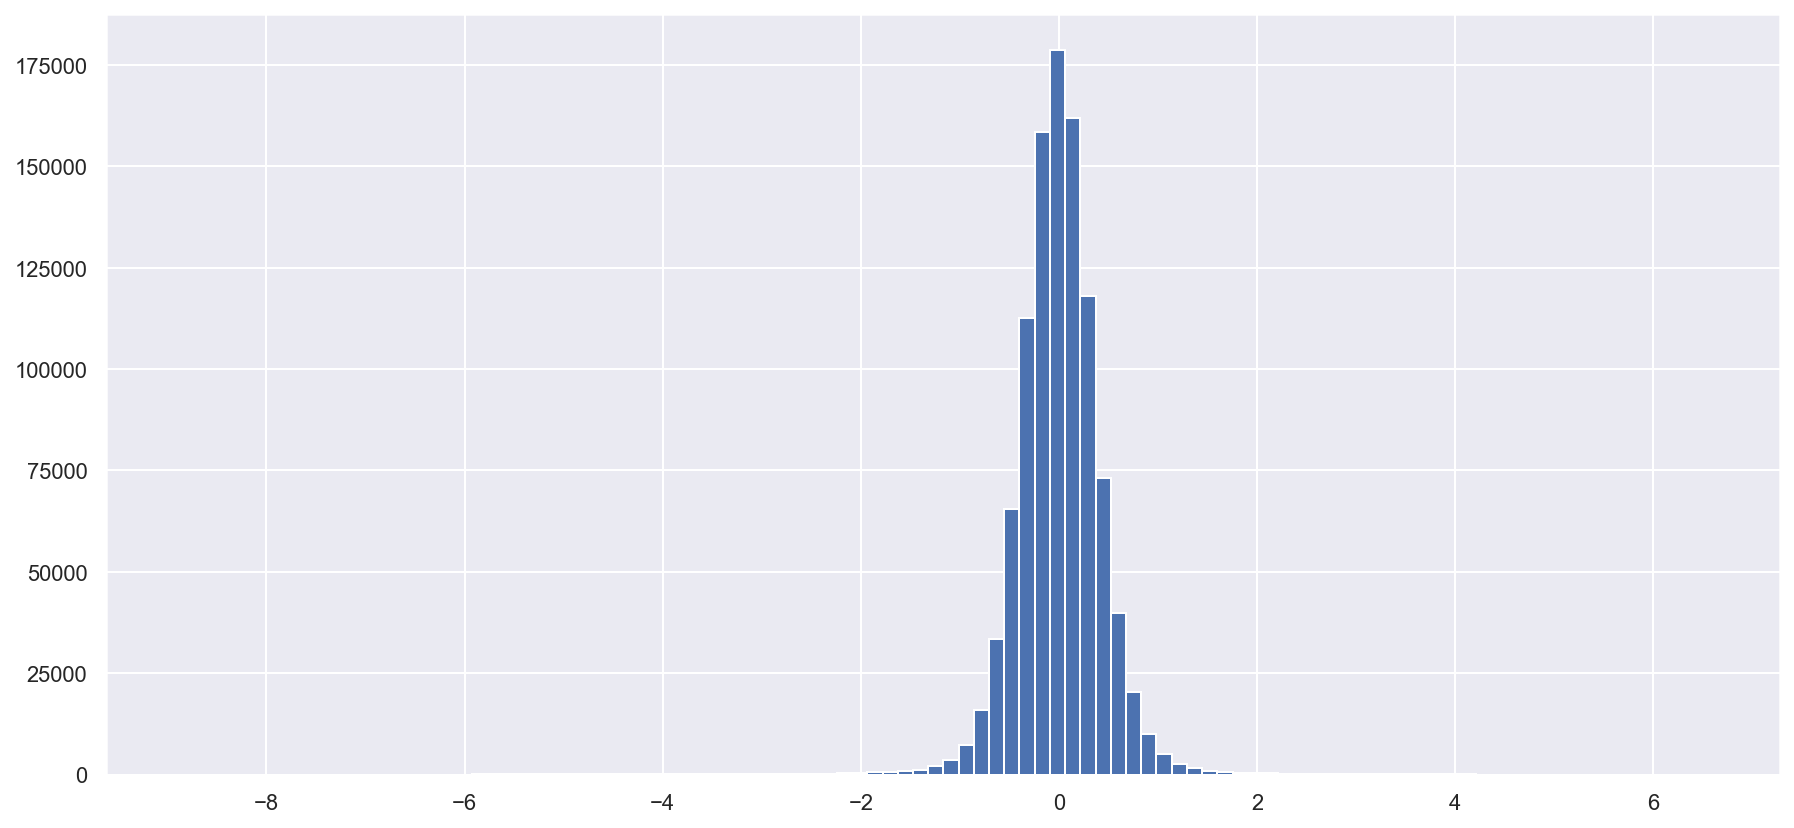

In [73]:
for el in columns:
    X_train[el].hist(bins =100)
    plt.show()

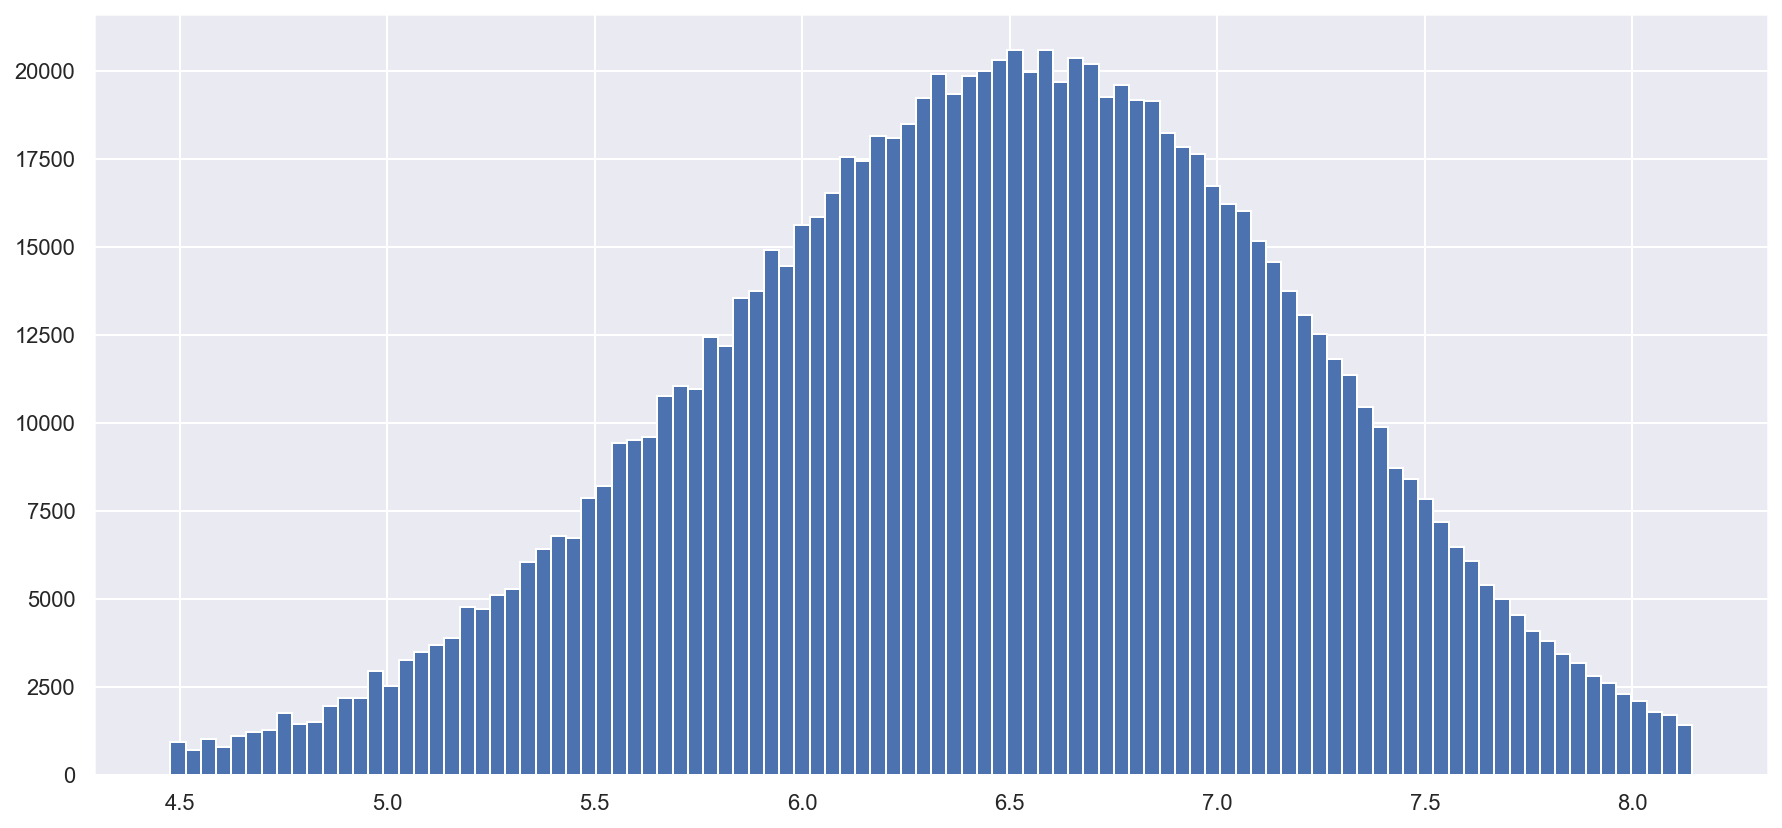

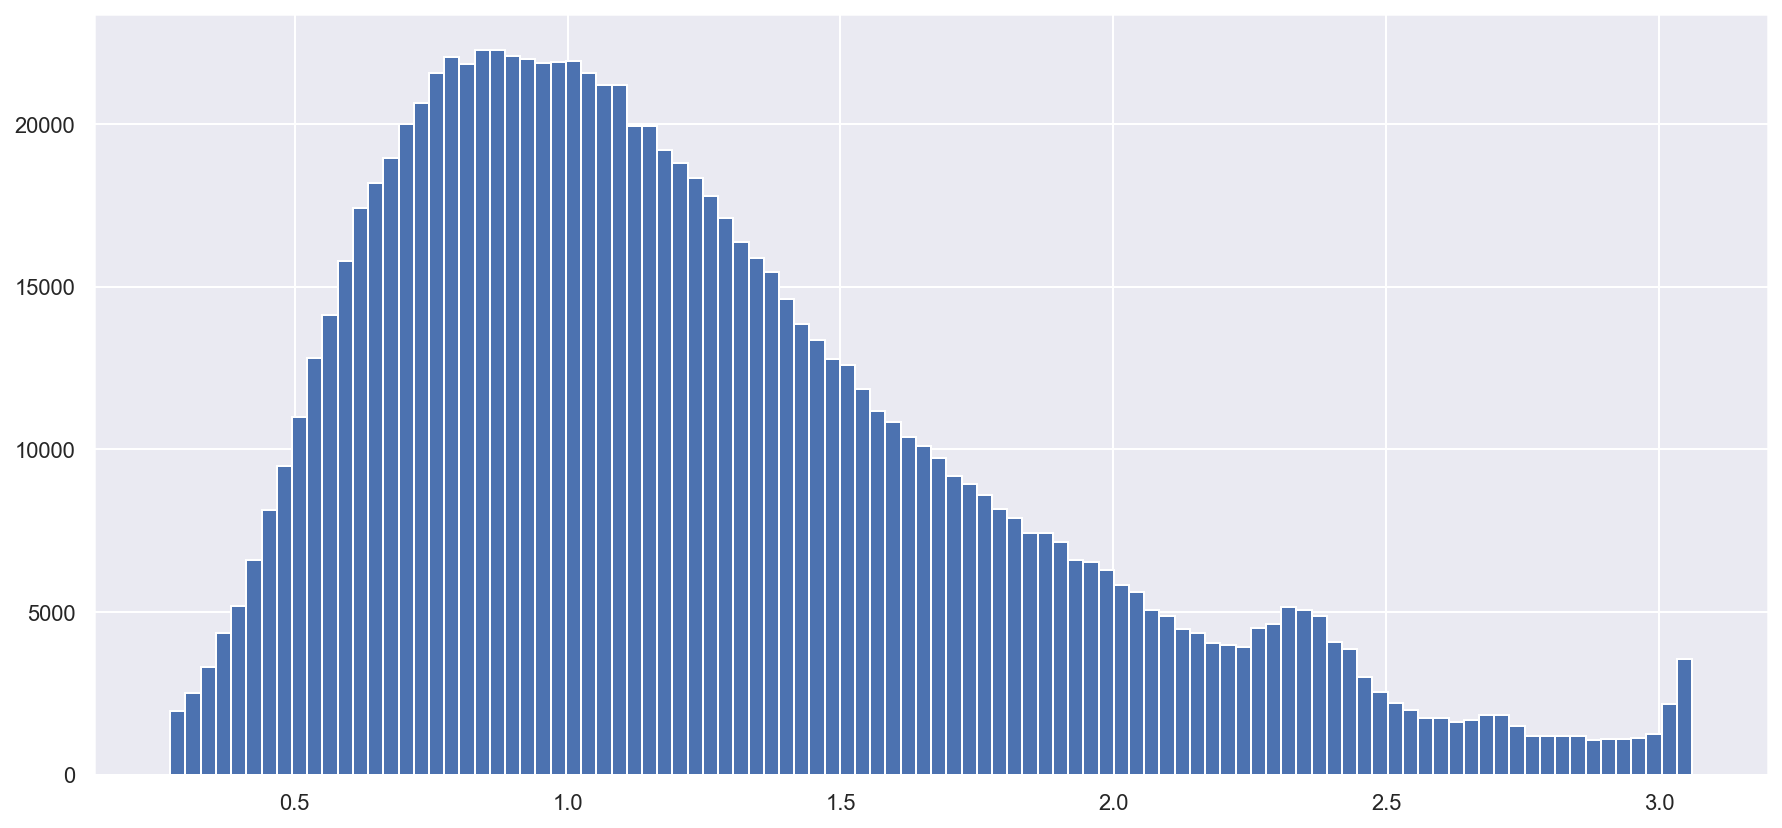

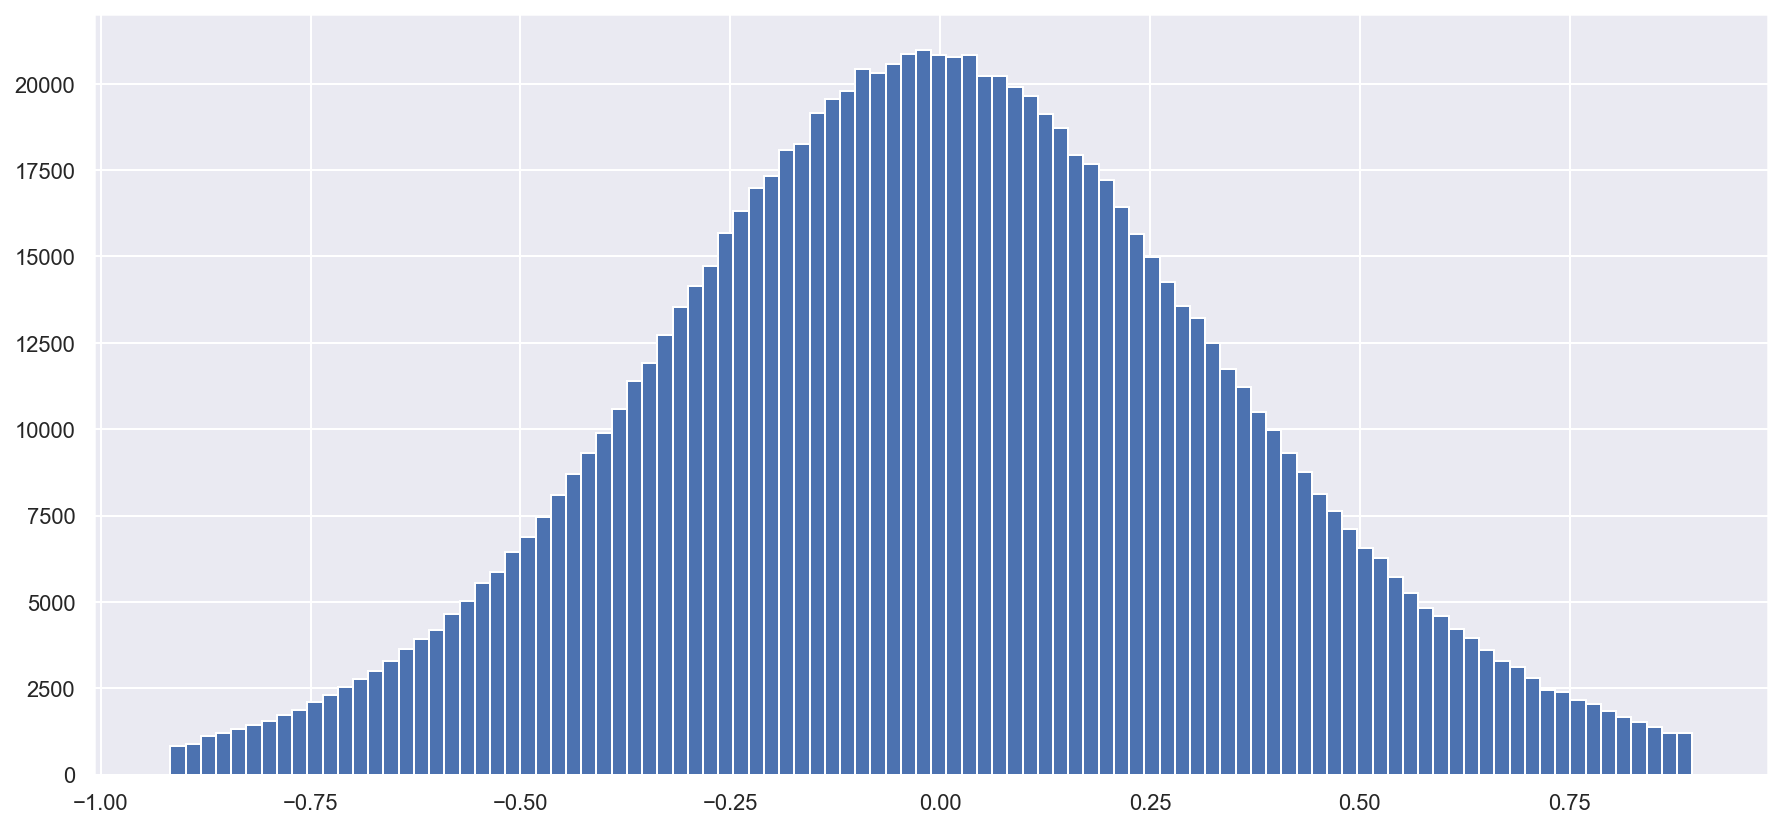

In [74]:
for el in columns:
    X_train = X_train[exclude_outliers(X_train, el)]
    X_train[el].hist(bins =100)
    plt.show()

In [75]:
numeric_features = ['log_haversine']

categorical = ['pickup_weekday', 'pickup_hour', 'pickup_month',
       'pickup_day', 'is_anomal_1', 'is_anomal_2', 'is_traffic_jam', 'is_airport_dropoff', 'is_airport_pickup', 'square_pickup', 'square_dropoff', 'vendor_id', 'store_and_fwd_flag']

MGT = MapGridTransformer(quantile = 0.997, n_l = 110, n_w = 110)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[('map_grid_transformer', MGT),
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha = 150))
    ])

In [77]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test RMSE = %f" % mean_squared_error(y_test, y_pred, squared=False))

ValueError: Found input variables with inconsistent numbers of samples: [961056, 1021050]

In [79]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

ohe = OneHotEncoder(handle_unknown="ignore")
transformed = ohe.fit_transform(data[categorical])
print(transformed.toarray())


KeyError: "['square_pickup', 'square_dropoff'] not in index"

In [ ]:
numeric_features = ['log_haversine']

categorical = ['pickup_weekday', 'pickup_hour', 'pickup_month',
       'pickup_day', 'is_anomal_1', 'is_anomal_2', 'is_traffic_jam', 'is_airport_dropoff', 'is_airport_pickup', 'square_pickup', 'square_dropoff', 'vendor_id', 'store_and_fwd_flag']

MGT = MapGridTransformer(quantile = 0.997, n_l = 110, n_w = 110)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[('map_grid_transformer', MGT),
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha = 150))
    ])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test RMSE = %f" % mean_squared_error(y_test, y_pred, squared=False))